# 🏢 PRÉDICTION ÉMISSIONS GES - BÂTIMENTS SEATTLE
## Notebook 04 : Modélisation Complète avec Pipelines

---

### 📋 Informations

**Dataset** : 1,666 bâtiments (2015-2016)  
**Objectif** : Comparer 2 approches prédictives  
**Date** : Janvier 2026

### 🎯 Les 2 Modèles

1. **Modèle 1** : Variables disponibles au permis (sans ENERGY STAR)
2. **Modèle 2** : Avec ENERGY STAR Score

---

# Section 0 : Configuration et Imports

In [3]:
# ============================================================================
# IMPORTS STANDARDS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')
import importlib.util
from datetime import datetime
import time
import importlib.util

# ============================================================================
# CONFIGURATION CHEMINS - VERSION CORRIGÉE
# ============================================================================

# Chemin absolu du projet
PROJECT_ROOT = Path(r"C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation")

# Vérifier que le projet existe
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"❌ Le projet n'existe pas à : {PROJECT_ROOT}")

SRC_PATH = PROJECT_ROOT / 'src'

if not SRC_PATH.exists():
    raise FileNotFoundError(f"❌ Le dossier src n'existe pas à : {SRC_PATH}")

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"✓ PROJECT_ROOT : {PROJECT_ROOT}")
print(f"✓ SRC_PATH : {SRC_PATH}")
print(f"✓ Chemins configurés")

✓ PROJECT_ROOT : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation
✓ SRC_PATH : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\src
✓ Chemins configurés


In [4]:
# ============================================================================
# IMPORTS MODULES PERSONNALISÉS
# ============================================================================

# modeling_utils
spec_modeling = importlib.util.spec_from_file_location("modeling_utils", SRC_PATH / "modeling_utils.py")
modeling_utils = importlib.util.module_from_spec(spec_modeling)
spec_modeling.loader.exec_module(modeling_utils)

# evaluation_utils
spec_eval = importlib.util.spec_from_file_location("evaluation_utils", SRC_PATH / "evaluation_utils.py")
evaluation_utils = importlib.util.module_from_spec(spec_eval)
spec_eval.loader.exec_module(evaluation_utils)

# visualization_utils
spec_viz = importlib.util.spec_from_file_location("visualization_utils", SRC_PATH / "visualization_utils.py")
visualization_utils = importlib.util.module_from_spec(spec_viz)
spec_viz.loader.exec_module(visualization_utils)

# Extraire fonctions
train_multiple_models = modeling_utils.train_multiple_models
save_model = modeling_utils.save_model
get_feature_importance = modeling_utils.get_feature_importance
compare_models = modeling_utils.compare_models

evaluate_model = evaluation_utils.evaluate_model
cv_evaluate_model = evaluation_utils.cv_evaluate_model
compute_residuals_stats = evaluation_utils.compute_residuals_stats
calculate_metrics_summary = evaluation_utils.calculate_metrics_summary
compare_model_performance = evaluation_utils.compare_model_performance

plot_predictions = visualization_utils.plot_predictions
plot_residuals_distribution = visualization_utils.plot_residuals_distribution
plot_feature_importance = visualization_utils.plot_feature_importance
plot_model_comparison = visualization_utils.plot_model_comparison
plot_comparison_two_models = visualization_utils.plot_comparison_two_models

print("✓ Modules personnalisés importés")

✓ Modules personnalisés importés


In [5]:
# ============================================================================
# SCIKIT-LEARN
# ============================================================================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error


print("\n" + "="*80)
print("IMPORTS TERMINÉS")
print("="*80)


IMPORTS TERMINÉS


In [6]:
# ============================================================================
# CONFIGURATION
# ============================================================================

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

# Chemins
DATA_DIR = PROJECT_ROOT / 'data'
INTERIM_DIR = DATA_DIR / 'interim_data'
MODELS_DIR = PROJECT_ROOT / 'models'
RESULTS_DIR = PROJECT_ROOT / 'results'
FIGURES_DIR = RESULTS_DIR / 'figures'
OPTIM_DIR = RESULTS_DIR / 'optimization'

for directory in [MODELS_DIR, RESULTS_DIR, FIGURES_DIR, OPTIM_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("✓ Configuration terminée")

✓ Configuration terminée


# Section 1 : Chargement des Données

In [7]:
print("="*80)
print("CHARGEMENT DES DONNÉES")
print("="*80)

train_df = pd.read_csv(INTERIM_DIR / 'train_with_features.csv')
test_df = pd.read_csv(INTERIM_DIR / 'test_with_features.csv')

print(f"\n✓ Train : {train_df.shape}")
print(f"✓ Test  : {test_df.shape}")

display(train_df.head())

CHARGEMENT DES DONNÉES

✓ Train : (1332, 31)
✓ Test  : (334, 31)


,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,Neighborhood,Latitude,Longitude,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kWh),NaturalGas(therms),TotalGHGEmissions,TotalGHGEmissions_log,GFA_per_floor,Parking_ratio,Building_age_squared,Is_old_building,Size_floors,Age_size,Age_floors,GFA_sqrt,Floors_squared,Neighborhood_mean,Neighborhood_std,PrimaryPropertyType_mean,PrimaryPropertyType_std
0,23701.0,NonResidential,Warehouse,1136 S. Albro Place,GREATER DUWAMISH,47.5465,-122.3170,"Non-Refrigerated Warehouse, Office",Non-Refrigerated Warehouse,28000.0,Office,4000.0,73.0,0.0000,5.7582e+05,0.0000,13.700,2.6878,31899.9681,0.0,2809,1,31900.0,1.6907e+06,53.0,178.6057,1.0000,3.5022,1.2672,3.1054,1.1998
1,401.0,NonResidential,Hotel,1325 6th Ave,DOWNTOWN,47.6097,-122.3338,Hotel,Hotel,310000.0,Parking,11745.0,58.0,845964.4438,4.2726e+06,28667.0488,564.285,6.3373,24542.0061,0.0,7396,1,3804072.6,2.6277e+07,1070.7,552.7640,155.0025,4.3391,1.3719,5.2003,1.0251
2,238.0,Nonresidential COS,Small- and Mid-Sized Office,1300 N 97th ST,NORTHWEST,47.7004,-122.3414,"Data Center, Distribution Center, Office, Othe...",Office,57968.0,Distribution Center,32881.0,73.0,0.0000,2.0791e+06,23783.7305,175.770,5.1748,45564.9772,0.0,3481,1,182260.0,5.3767e+06,118.0,301.8775,4.0000,3.9741,1.3084,3.2973,0.9073
3,600.0,NonResidential,Warehouse,4100 4th Avenue South,GREATER DUWAMISH,47.5656,-122.3289,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,98480.0,Parking,11745.0,65.0,0.0000,7.0438e+05,4282.1802,39.500,3.7013,98479.9015,0.0,3600,1,98480.0,5.9088e+06,60.0,313.8152,1.0000,3.5022,1.2672,3.1054,1.1998
4,21336.0,NonResidential,Other,1004 Boren Ave,EAST,47.6097,-122.3250,Social/Meeting Hall,Social/Meeting Hall,20411.0,Parking,11745.0,73.0,0.0000,2.2712e+05,12395.3301,71.230,4.2799,7012.7310,0.0,10816,1,63114.6,2.1880e+06,312.0,145.0455,9.0000,4.2241,1.3597,4.2822,1.3053


# Section 2 : Analyse de la Target

In [8]:
TARGET = 'TotalGHGEmissions_log'

if TARGET not in train_df.columns:
    print(f"⚠ Création de {TARGET}...")
    train_df[TARGET] = np.log1p(train_df['TotalGHGEmissions'])
    test_df[TARGET] = np.log1p(test_df['TotalGHGEmissions'])

y_train = train_df[TARGET]
y_test = test_df[TARGET]

print("="*80)
print("ANALYSE TARGET")
print("="*80)
print("\nTrain :")
print(y_train.describe())
print("\nTest :")
print(y_test.describe())

ANALYSE TARGET

Train :
count    1332.0000
mean        3.9679
std         1.3305
min         1.5196
25%         3.0392
50%         3.9330
75%         4.9220
max         6.3373
Name: TotalGHGEmissions_log, dtype: float64

Test :
count    334.0000
mean       3.9886
std        1.2895
min        1.5196
25%        3.0602
50%        3.8889
75%        5.0138
max        6.3373
Name: TotalGHGEmissions_log, dtype: float64


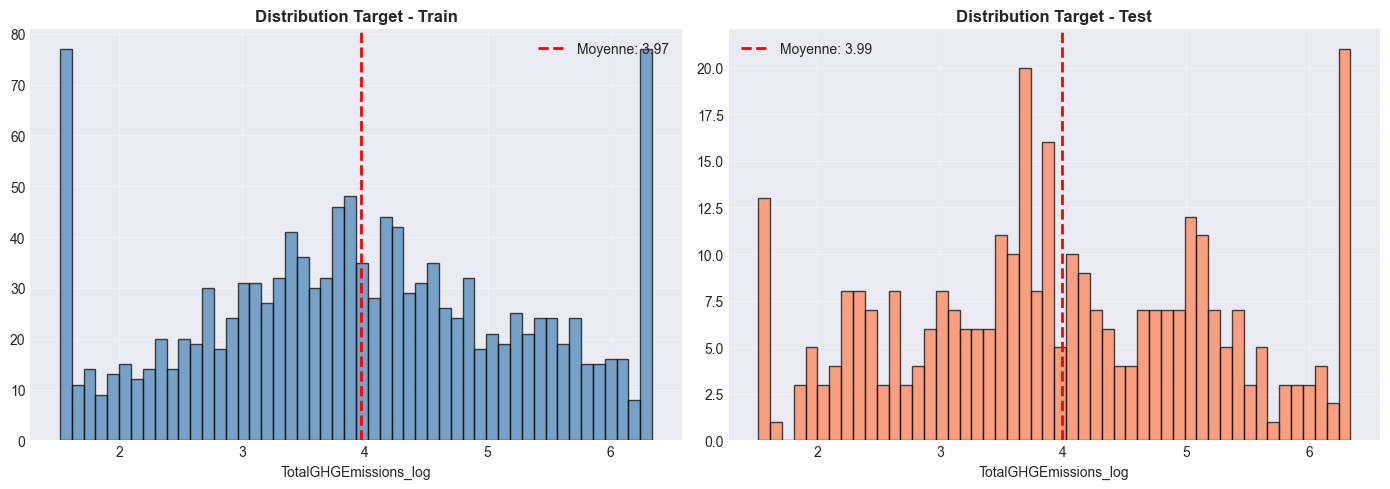

In [9]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {y_train.mean():.2f}')
axes[0].set_title('Distribution Target - Train', fontweight='bold')
axes[0].set_xlabel(TARGET)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_test, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {y_test.mean():.2f}')
axes[1].set_title('Distribution Target - Test', fontweight='bold')
axes[1].set_xlabel(TARGET)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Section 3 : Définition des Variables

In [10]:
# ============================================================================
# VARIABLES À EXCLURE
# ============================================================================

variables_a_exclure = [
    # IDs
    'OSEBuildingID', 'DataYear', 'PropertyName', 'Address',
    'TaxParcelIdentificationNumber',
    # Target
    'TotalGHGEmissions', 'TotalGHGEmissions_log',
    # Autres
    'Comments', 'ComplianceStatus', 'Outlier', 'DefaultData'
]

# ============================================================================
# MODÈLE 1 : SANS ENERGY STAR
# ============================================================================

toutes_colonnes = train_df.columns.tolist()
variables_m1 = [
    col for col in toutes_colonnes 
    if col not in variables_a_exclure and col != 'ENERGYSTARScore'
]

# ============================================================================
# MODÈLE 2 : AVEC ENERGY STAR
# ============================================================================

variables_m2 = variables_m1.copy()
if 'ENERGYSTARScore' in train_df.columns:
    variables_m2.append('ENERGYSTARScore')

print(f" MODÈLE 1 : {len(variables_m1)} features")
print(f" MODÈLE 2 : {len(variables_m2)} features")
print(f" Target : {TARGET}")

 MODÈLE 1 : 26 features
 MODÈLE 2 : 27 features
 Target : TotalGHGEmissions_log


# Section 4 : Préparation des Datasets

In [11]:
# ============================================================================
# MODÈLE 1
# ============================================================================

print("="*80)
print("PRÉPARATION MODÈLE 1")
print("="*80)

X_train_m1 = train_df[variables_m1].copy()
X_test_m1 = test_df[variables_m1].copy()

# Gestion variables catégorielles
categorical_cols = X_train_m1.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    print(f"\n⚠ {len(categorical_cols)} variables catégorielles → OneHotEncoding")
    X_train_m1 = pd.get_dummies(X_train_m1, columns=categorical_cols, drop_first=True)
    X_test_m1 = pd.get_dummies(X_test_m1, columns=categorical_cols, drop_first=True)
    X_train_m1, X_test_m1 = X_train_m1.align(X_test_m1, join='left', axis=1, fill_value=0)
    print(f"   ✓ {X_train_m1.shape[1]} features après encodage")

print(f"\n✓ X_train_m1 : {X_train_m1.shape}")
print(f"✓ X_test_m1  : {X_test_m1.shape}")

PRÉPARATION MODÈLE 1

⚠ 6 variables catégorielles → OneHotEncoding
   ✓ 465 features après encodage

✓ X_train_m1 : (1332, 465)
✓ X_test_m1  : (334, 465)


In [12]:
# ============================================================================
# MODÈLE 2
# ============================================================================

print("="*80)
print("PRÉPARATION MODÈLE 2")
print("="*80)

X_train_m2 = train_df[variables_m2].copy()
X_test_m2 = test_df[variables_m2].copy()

# Imputation ENERGY STAR
if 'ENERGYSTARScore' in X_train_m2.columns:
    missing = X_train_m2['ENERGYSTARScore'].isnull().sum()
    if missing > 0:
        print(f"\n⚠ {missing} valeurs manquantes ENERGYSTARScore")
        median_val = X_train_m2['ENERGYSTARScore'].median()
        X_train_m2['ENERGYSTARScore'].fillna(median_val, inplace=True)
        X_test_m2['ENERGYSTARScore'].fillna(median_val, inplace=True)
        print(f"   ✓ Imputation médiane = {median_val:.2f}")

# Gestion variables catégorielles
categorical_cols_m2 = X_train_m2.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols_m2) > 0:
    print(f"\n⚠ {len(categorical_cols_m2)} variables catégorielles → OneHotEncoding")
    X_train_m2 = pd.get_dummies(X_train_m2, columns=categorical_cols_m2, drop_first=True)
    X_test_m2 = pd.get_dummies(X_test_m2, columns=categorical_cols_m2, drop_first=True)
    X_train_m2, X_test_m2 = X_train_m2.align(X_test_m2, join='left', axis=1, fill_value=0)
    print(f"   ✓ {X_train_m2.shape[1]} features après encodage")

print(f"\n✓ X_train_m2 : {X_train_m2.shape}")
print(f"✓ X_test_m2  : {X_test_m2.shape}")

PRÉPARATION MODÈLE 2

⚠ 6 variables catégorielles → OneHotEncoding
   ✓ 466 features après encodage

✓ X_train_m2 : (1332, 466)
✓ X_test_m2  : (334, 466)


# Section 5 : MODÈLE 1 - Baseline avec Pipelines

In [13]:
# ============================================================================
# DÉFINITION PIPELINES - MODÈLE 1
# ============================================================================

print("="*80)
print("MODÈLE 1 - BASELINE AVEC PIPELINES")
print("="*80)

pipelines_m1 = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=RANDOM_STATE))
    ]),
    
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE
        ))
    ]),
    
    'SVR': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf'))
    ])
}


print(f"\n✓ {len(pipelines_m1)} pipelines créés")

MODÈLE 1 - BASELINE AVEC PIPELINES

✓ 5 pipelines créés


In [14]:
# ============================================================================
# ENTRAÎNEMENT - MODÈLE 1
# ============================================================================

results_df_m1, trained_pipelines_m1 = train_multiple_models(
    pipelines_m1,
    X_train_m1,
    y_train,
    X_test_m1,
    y_test,
    cv=5,
    verbose=True
)

print("\n RÉSULTATS BASELINE - MODÈLE 1")
display(results_df_m1[['model', 'test_r2', 'test_rmse_log', 'test_mae_log', 
                       'test_rmse_original', 'test_mape', 'overfitting_r2']].round(4))

ENTRAÎNEMENT MULTIPLE MODÈLES

Nombre de modèles : 5
Cross-validation : 5-fold

Traitement : Ridge
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 9.40s
   R² Test : 0.6710
   RMSE Test : 0.7385

Traitement : Lasso
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 3.79s
   R² Test : -0.0003
   RMSE Test : 1.2878

Traitement : Random Forest
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 7.98s
   R² Test : 0.9835
   RMSE Test : 0.1652

Traitement : Gradient Boosting
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 5.05s
   R² Test : 0.9846
   RMSE Test : 0.1599

Traitement : SVR
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 4.01s
   R² Test : 0.6166
   RMSE Test : 0.7973

✓ ENTRAÎNEMENT TERMINÉ

 RÉSULTATS BASELINE - MODÈLE 1


,model,test_r2,test_rmse_log,test_mae_log,test_rmse_original,test_mape,overfitting_r2
3,Gradient Boosting,0.9846,0.1599,0.0875,52.0893,9.0482,0.0127
2,Random Forest,0.9835,0.1652,0.0724,50.3570,7.5391,0.0150
0,Ridge,0.6710,0.7385,0.5687,267.4425,78.8166,0.1716
4,SVR,0.6166,0.7973,0.5866,101.5368,99.6010,0.1533
1,Lasso,-0.0003,1.2878,1.0602,161.4327,184.8346,0.0003


✓ Figure sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\figures\baseline_m1.png


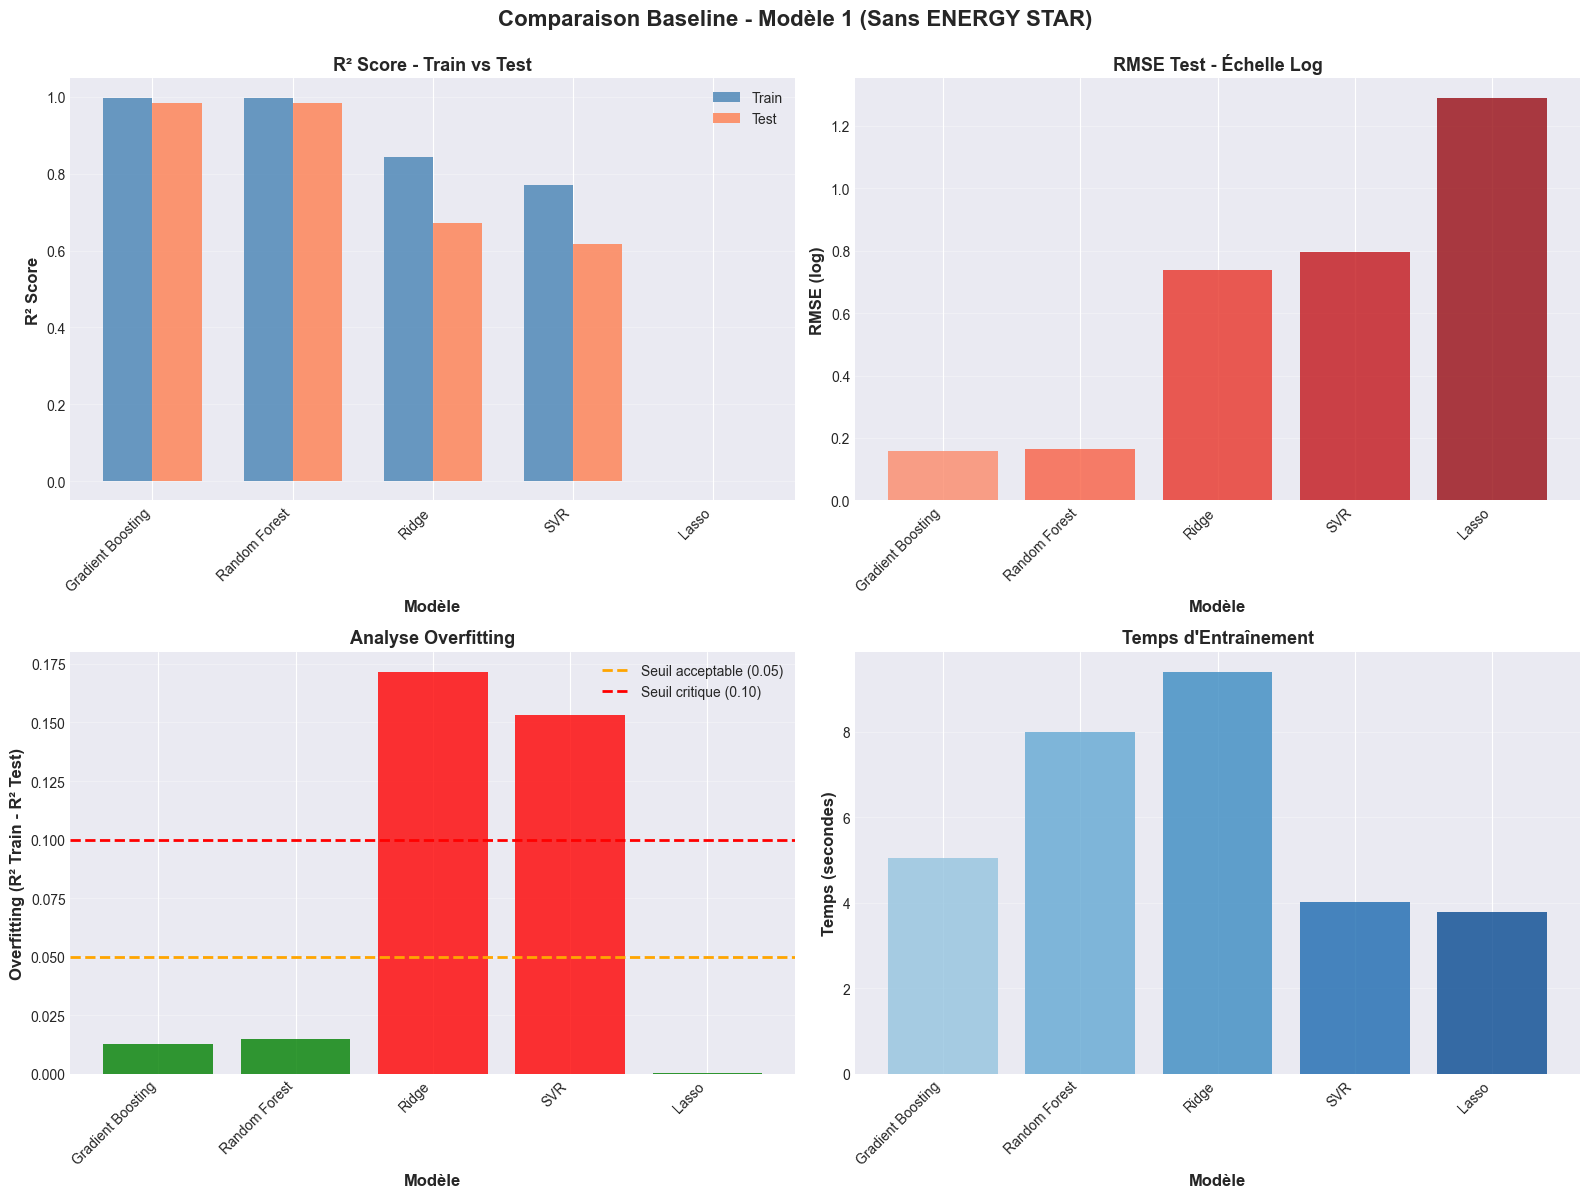

In [15]:
# Visualisation
plot_model_comparison(
    results_df_m1,
    title="Comparaison Baseline - Modèle 1 (Sans ENERGY STAR)",
    save_path=FIGURES_DIR / 'baseline_m1.png'
)

# Section 6 : MODÈLE 1 - Analyse

In [16]:
# ============================================================================
# MEILLEUR MODÈLE - MODÈLE 1
# ============================================================================

best_model_name_m1 = results_df_m1.iloc[0]['model']
best_pipeline_m1 = trained_pipelines_m1[best_model_name_m1]
best_metrics_m1 = results_df_m1.iloc[0].to_dict()

print("="*80)
print(f"MEILLEUR MODÈLE 1 : {best_model_name_m1}")
print("="*80)

summary_m1 = calculate_metrics_summary(best_metrics_m1)
display(summary_m1)

MEILLEUR MODÈLE 1 : Gradient Boosting


,Métrique,Valeur,Interprétation
0,R² Score (Test),0.9846,Excellent
1,RMSE (échelle originale),52.09 tonnes CO₂,Erreur moyenne quadratique
2,MAPE (%),9.05%,Excellent
3,Overfitting (R²),0.0127,Pas d'overfitting


✓ Figure sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\figures\feature_importance_m1.png


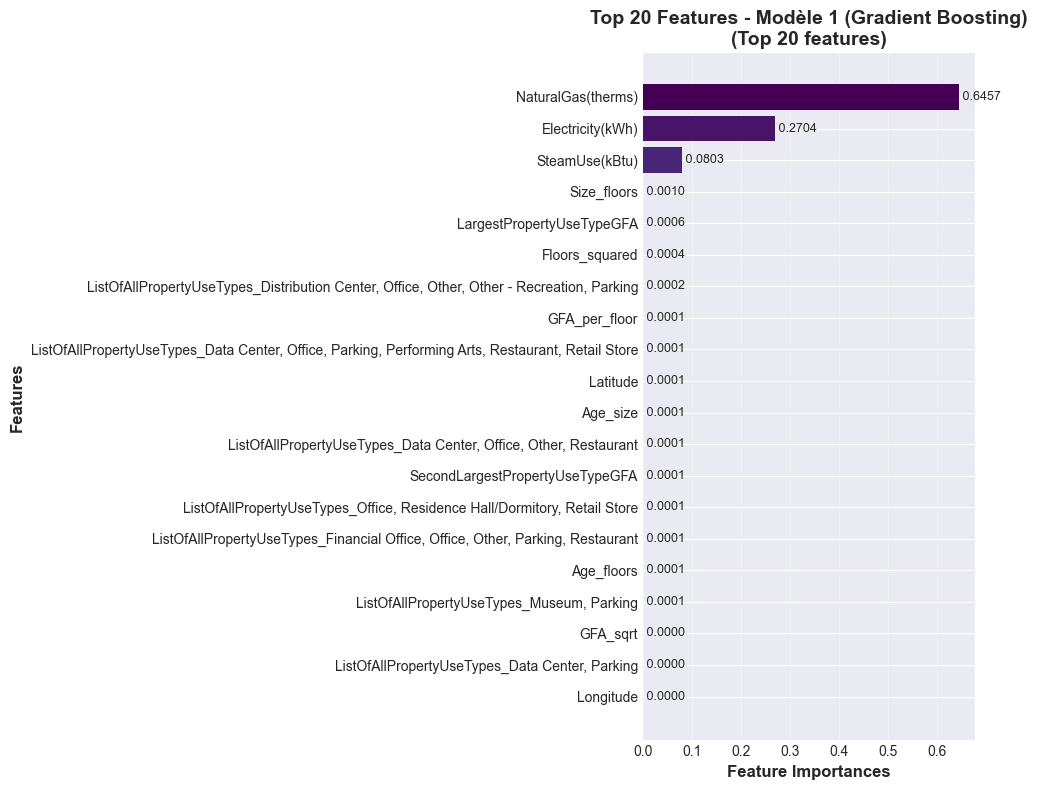


Top 10 Features :


,feature,importance
6,NaturalGas(therms),0.6457
5,Electricity(kWh),0.2704
4,SteamUse(kBtu),0.0803
11,Size_floors,0.0010
2,LargestPropertyUseTypeGFA,0.0006
15,Floors_squared,0.0004
122,"ListOfAllPropertyUseTypes_Distribution Center,...",0.0002
7,GFA_per_floor,0.0001
109,"ListOfAllPropertyUseTypes_Data Center, Office,...",0.0001
0,Latitude,0.0001


In [17]:
# Feature Importance
if hasattr(best_pipeline_m1.named_steps['model'], 'feature_importances_') or \
   hasattr(best_pipeline_m1.named_steps['model'], 'coef_'):
    
    importance_df_m1 = plot_feature_importance(
        best_pipeline_m1.named_steps['model'],
        X_train_m1.columns,
        top_n=20,
        title=f"Top 20 Features - Modèle 1 ({best_model_name_m1})",
        save_path=FIGURES_DIR / 'feature_importance_m1.png'
    )
    
    print("\nTop 10 Features :")
    display(importance_df_m1.head(10))
else:
    print("⚠ Feature importance non disponible pour ce modèle")

✓ Figure sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\figures\predictions_m1.png


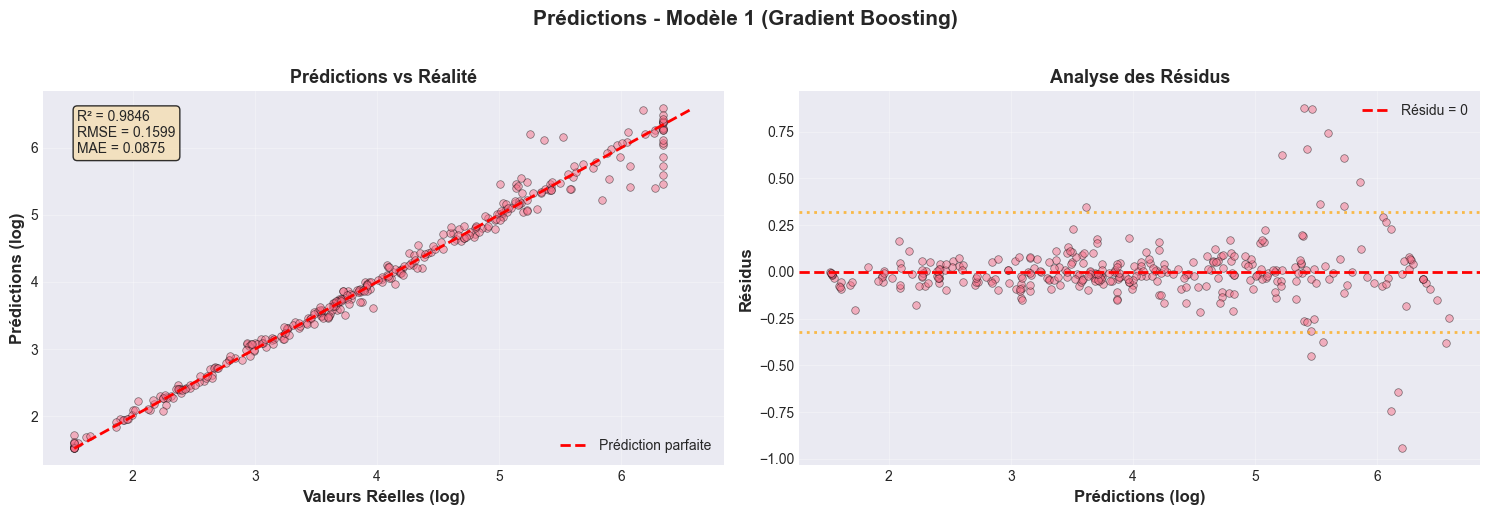

✓ Figure sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\figures\residuals_m1.png


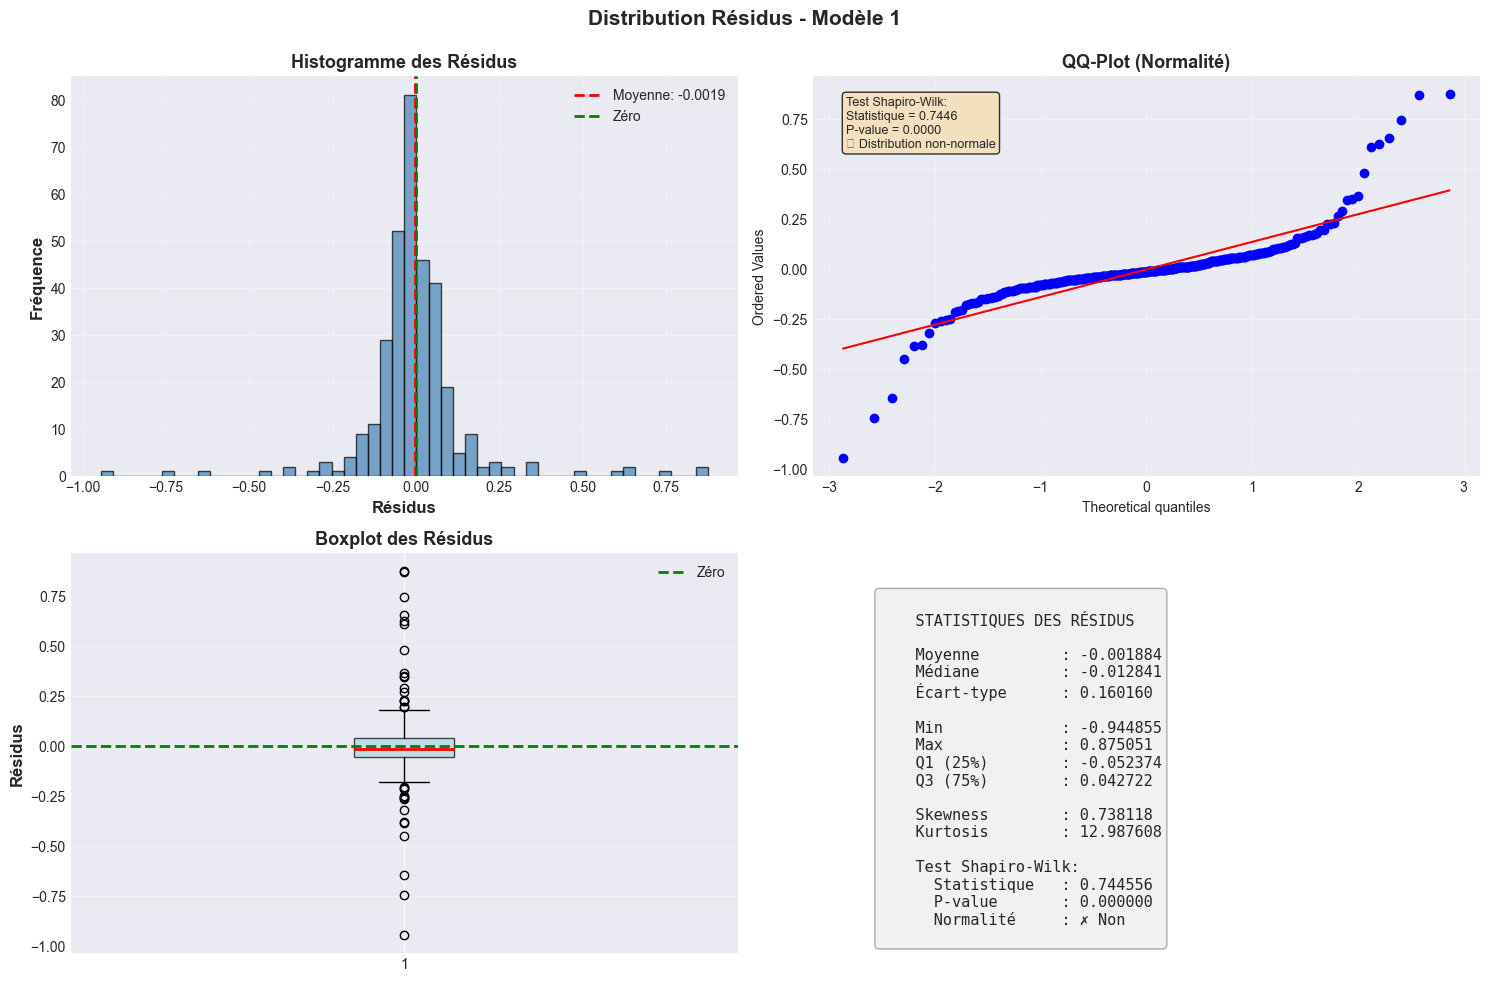

In [18]:
# Analyse Résidus
y_pred_m1 = best_pipeline_m1.predict(X_test_m1)

plot_predictions(
    y_test, y_pred_m1,
    title=f"Prédictions - Modèle 1 ({best_model_name_m1})",
    save_path=FIGURES_DIR / 'predictions_m1.png'
)

residuals_m1 = y_test - y_pred_m1
plot_residuals_distribution(
    residuals_m1,
    title="Distribution Résidus - Modèle 1",
    save_path=FIGURES_DIR / 'residuals_m1.png'
)

# Section 7 : MODÈLE 2 - Baseline avec Pipelines

In [19]:
# ============================================================================
# DÉFINITION PIPELINES - MODÈLE 2
# ============================================================================

print("="*80)
print("MODÈLE 2 - BASELINE AVEC PIPELINES")
print("="*80)

pipelines_m2 = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=RANDOM_STATE))
    ]),
    
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE
        ))
    ]),
    
    'SVR': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf'))
    ])
}



print(f"\n✓ {len(pipelines_m2)} pipelines créés")

MODÈLE 2 - BASELINE AVEC PIPELINES

✓ 5 pipelines créés


In [20]:
# ============================================================================
# ENTRAÎNEMENT - MODÈLE 2
# ============================================================================

results_df_m2, trained_pipelines_m2 = train_multiple_models(
    pipelines_m2,
    X_train_m2,
    y_train,
    X_test_m2,
    y_test,
    cv=5,
    verbose=True
)

print("\n📊 RÉSULTATS BASELINE - MODÈLE 2")
display(results_df_m2[['model', 'test_r2', 'test_rmse_log', 'test_mae_log', 
                       'test_rmse_original', 'test_mape', 'overfitting_r2']].round(4))

ENTRAÎNEMENT MULTIPLE MODÈLES

Nombre de modèles : 5
Cross-validation : 5-fold

Traitement : Ridge
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 0.33s
   R² Test : 0.6568
   RMSE Test : 0.7543

Traitement : Lasso
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 0.24s
   R² Test : -0.0003
   RMSE Test : 1.2878

Traitement : Random Forest
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 7.15s
   R² Test : 0.9850
   RMSE Test : 0.1580

Traitement : Gradient Boosting
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 4.42s
   R² Test : 0.9844
   RMSE Test : 0.1608

Traitement : SVR
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 4.45s
   R² Test : 0.6203
   RMSE Test : 0.7934

✓ ENTRAÎNEMENT TERMINÉ

📊 RÉSULTATS BASELINE - MODÈLE 2


,model,test_r2,test_rmse_log,test_mae_log,test_rmse_original,test_mape,overfitting_r2
2,Random Forest,0.9850,0.1580,0.0714,47.4485,7.3545,0.0136
3,Gradient Boosting,0.9844,0.1608,0.0874,52.0344,9.0131,0.0128
0,Ridge,0.6568,0.7543,0.5744,265.4036,80.7376,0.1924
4,SVR,0.6203,0.7934,0.5782,99.0464,99.3732,0.1602
1,Lasso,-0.0003,1.2878,1.0602,161.4327,184.8346,0.0003


✓ Figure sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\figures\baseline_m2.png


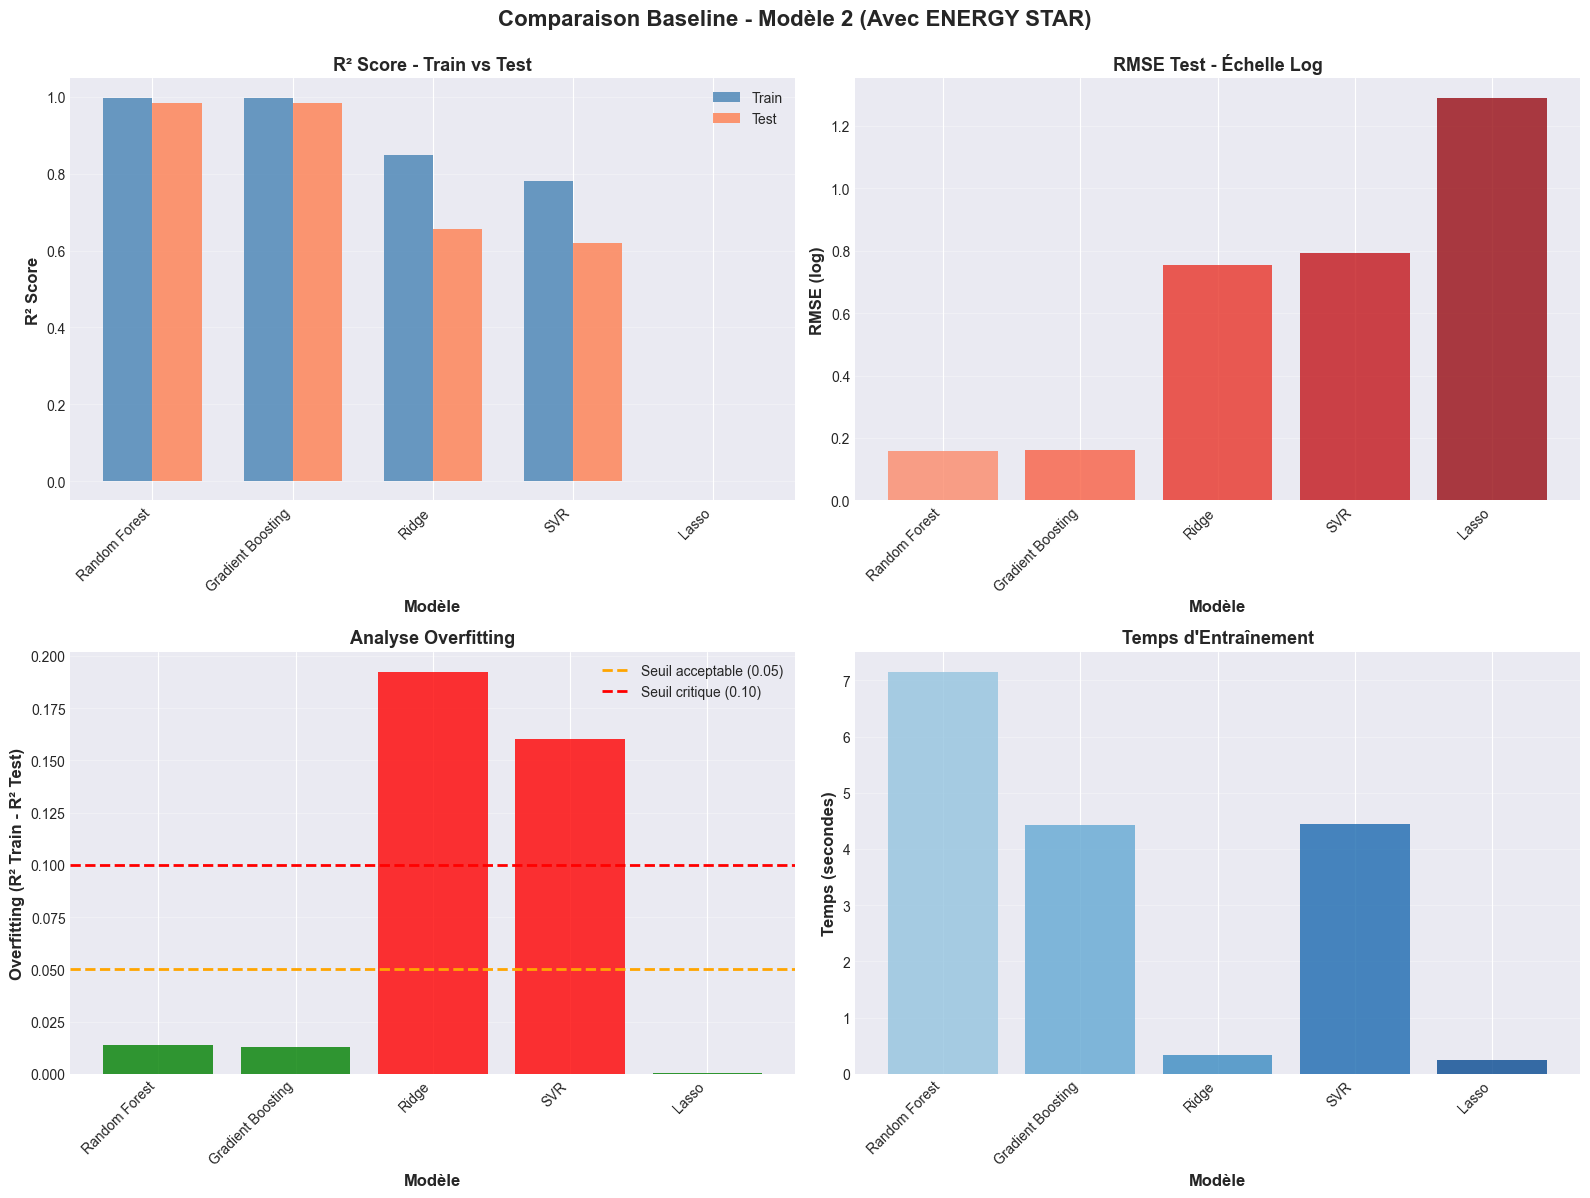

In [21]:
# Visualisation
plot_model_comparison(
    results_df_m2,
    title="Comparaison Baseline - Modèle 2 (Avec ENERGY STAR)",
    save_path=FIGURES_DIR / 'baseline_m2.png'
)

# Section 8 : MODÈLE 2 - Analyse

In [22]:
# ============================================================================
# MEILLEUR MODÈLE - MODÈLE 2
# ============================================================================

best_model_name_m2 = results_df_m2.iloc[0]['model']
best_pipeline_m2 = trained_pipelines_m2[best_model_name_m2]
best_metrics_m2 = results_df_m2.iloc[0].to_dict()

print("="*80)
print(f"MEILLEUR MODÈLE 2 : {best_model_name_m2}")
print("="*80)

summary_m2 = calculate_metrics_summary(best_metrics_m2)
display(summary_m2)

MEILLEUR MODÈLE 2 : Random Forest


,Métrique,Valeur,Interprétation
0,R² Score (Test),0.9850,Excellent
1,RMSE (échelle originale),47.45 tonnes CO₂,Erreur moyenne quadratique
2,MAPE (%),7.35%,Excellent
3,Overfitting (R²),0.0136,Pas d'overfitting


✓ Figure sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\figures\feature_importance_m2.png


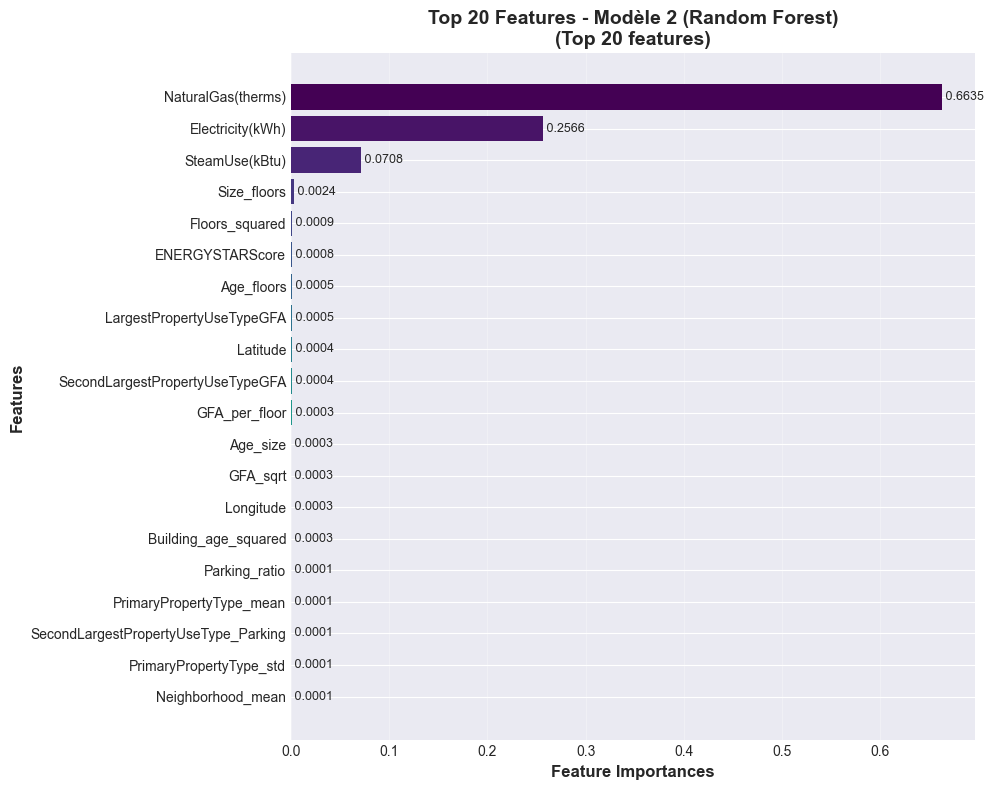


Top 10 Features :


,feature,importance
6,NaturalGas(therms),0.6635
5,Electricity(kWh),0.2566
4,SteamUse(kBtu),0.0708
11,Size_floors,0.0024
15,Floors_squared,0.0009
20,ENERGYSTARScore,0.0008
13,Age_floors,0.0005
2,LargestPropertyUseTypeGFA,0.0005
0,Latitude,0.0004
3,SecondLargestPropertyUseTypeGFA,0.0004



⭐ ENERGYSTARScore : Rang 21 | Importance 0.0008


In [23]:
# Feature Importance + Position ENERGY STAR
if hasattr(best_pipeline_m2.named_steps['model'], 'feature_importances_') or \
   hasattr(best_pipeline_m2.named_steps['model'], 'coef_'):
    
    importance_df_m2 = plot_feature_importance(
        best_pipeline_m2.named_steps['model'],
        X_train_m2.columns,
        top_n=20,
        title=f"Top 20 Features - Modèle 2 ({best_model_name_m2})",
        save_path=FIGURES_DIR / 'feature_importance_m2.png'
    )
    
    print("\nTop 10 Features :")
    display(importance_df_m2.head(10))
    
    # Position ENERGY STAR
    if 'ENERGYSTARScore' in importance_df_m2['feature'].values:
        energy_rank = importance_df_m2[importance_df_m2['feature'] == 'ENERGYSTARScore'].index[0] + 1
        energy_importance = importance_df_m2[importance_df_m2['feature'] == 'ENERGYSTARScore']['importance'].values[0]
        print(f"\n⭐ ENERGYSTARScore : Rang {energy_rank} | Importance {energy_importance:.4f}")
else:
    print("⚠ Feature importance non disponible")

✓ Figure sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\figures\predictions_m2.png


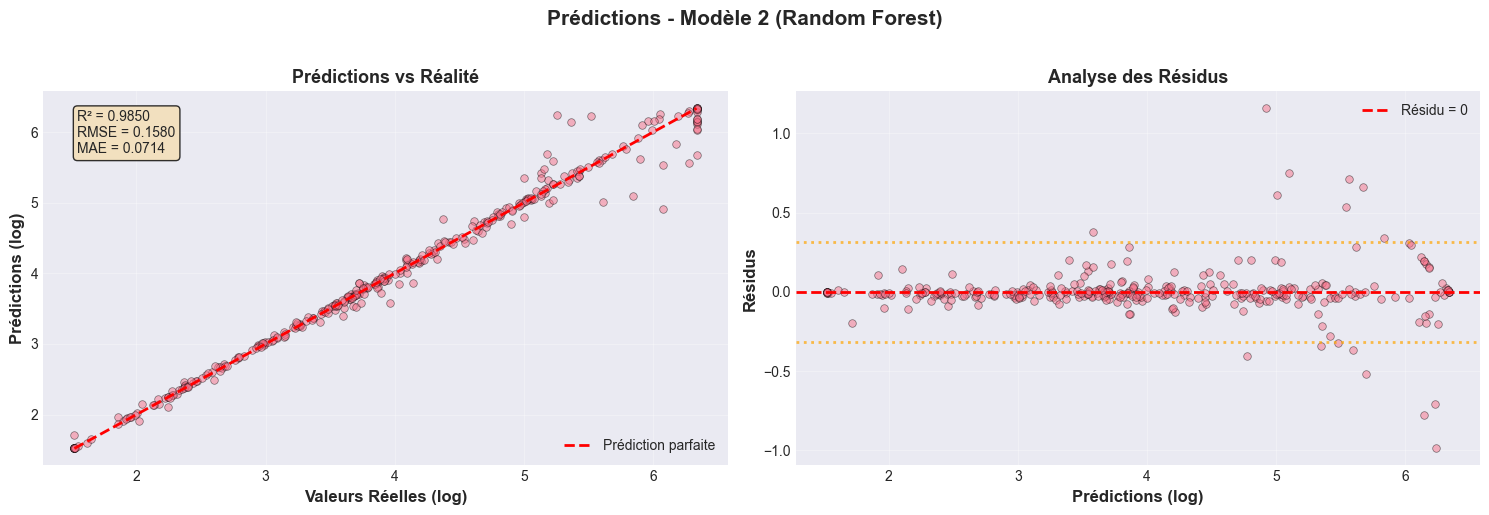

✓ Figure sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\figures\residuals_m2.png


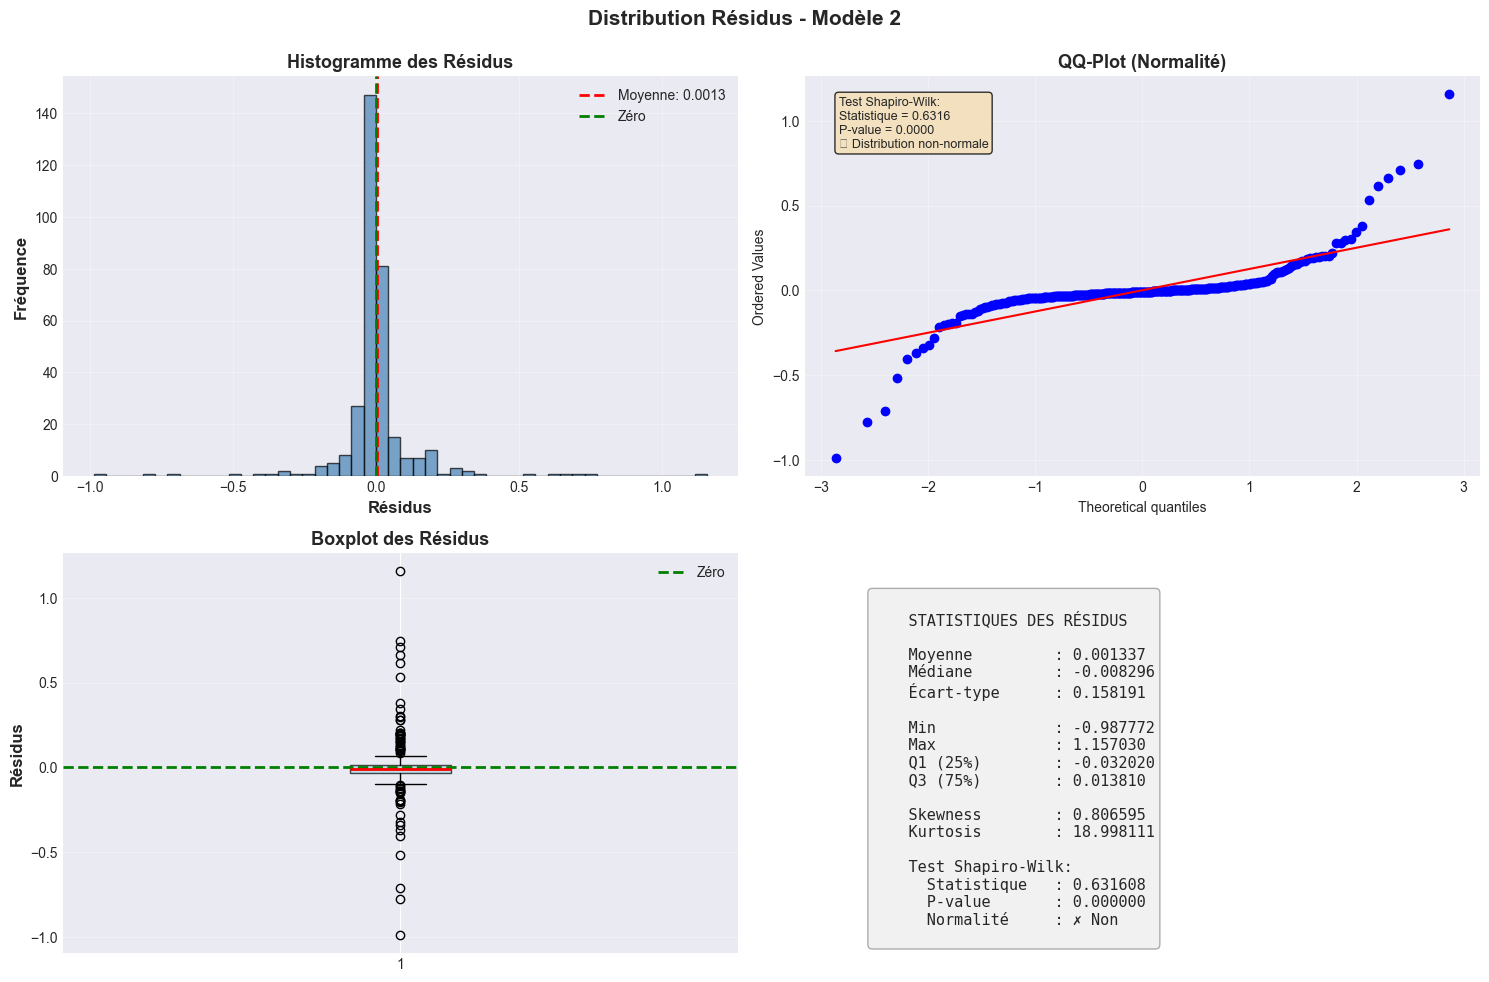

In [24]:
# Analyse Résidus
y_pred_m2 = best_pipeline_m2.predict(X_test_m2)

plot_predictions(
    y_test, y_pred_m2,
    title=f"Prédictions - Modèle 2 ({best_model_name_m2})",
    save_path=FIGURES_DIR / 'predictions_m2.png'
)

residuals_m2 = y_test - y_pred_m2
plot_residuals_distribution(
    residuals_m2,
    title="Distribution Résidus - Modèle 2",
    save_path=FIGURES_DIR / 'residuals_m2.png'
)

# Section 9 : Comparaison MODÈLE 1 vs MODÈLE 2

In [25]:
# ============================================================================
# COMPARAISON DÉTAILLÉE
# ============================================================================

print("="*80)
print("COMPARAISON MODÈLE 1 vs MODÈLE 2")
print("="*80)

comparison = compare_model_performance(
    best_metrics_m1,
    best_metrics_m2,
    "Modèle 1 (Sans ENERGY STAR)",
    "Modèle 2 (Avec ENERGY STAR)"
)

display(comparison)

COMPARAISON MODÈLE 1 vs MODÈLE 2


,Métrique,Modèle 1 (Sans ENERGY STAR),Modèle 2 (Avec ENERGY STAR),Différence,Amélioration (%),Meilleur
0,R² Test,0.9846,0.9850,+0.0004,+0.04%,Modèle 2 (Avec ENERGY STAR)
1,RMSE Test (log),0.1599,0.1580,-0.0020,+1.23%,Modèle 2 (Avec ENERGY STAR)
2,MAE Test (log),0.0875,0.0714,-0.0161,+18.45%,Modèle 2 (Avec ENERGY STAR)
3,RMSE Test (original),52.0893,47.4485,-4.6409,+8.91%,Modèle 2 (Avec ENERGY STAR)
4,MAPE Test (%),9.0482,7.3545,-1.6937,+18.72%,Modèle 2 (Avec ENERGY STAR)
5,Overfitting R²,0.0127,0.0136,+0.0009,-6.95%,Modèle 1 (Sans ENERGY STAR)


✓ Figure sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\figures\comparison_m1_m2.png


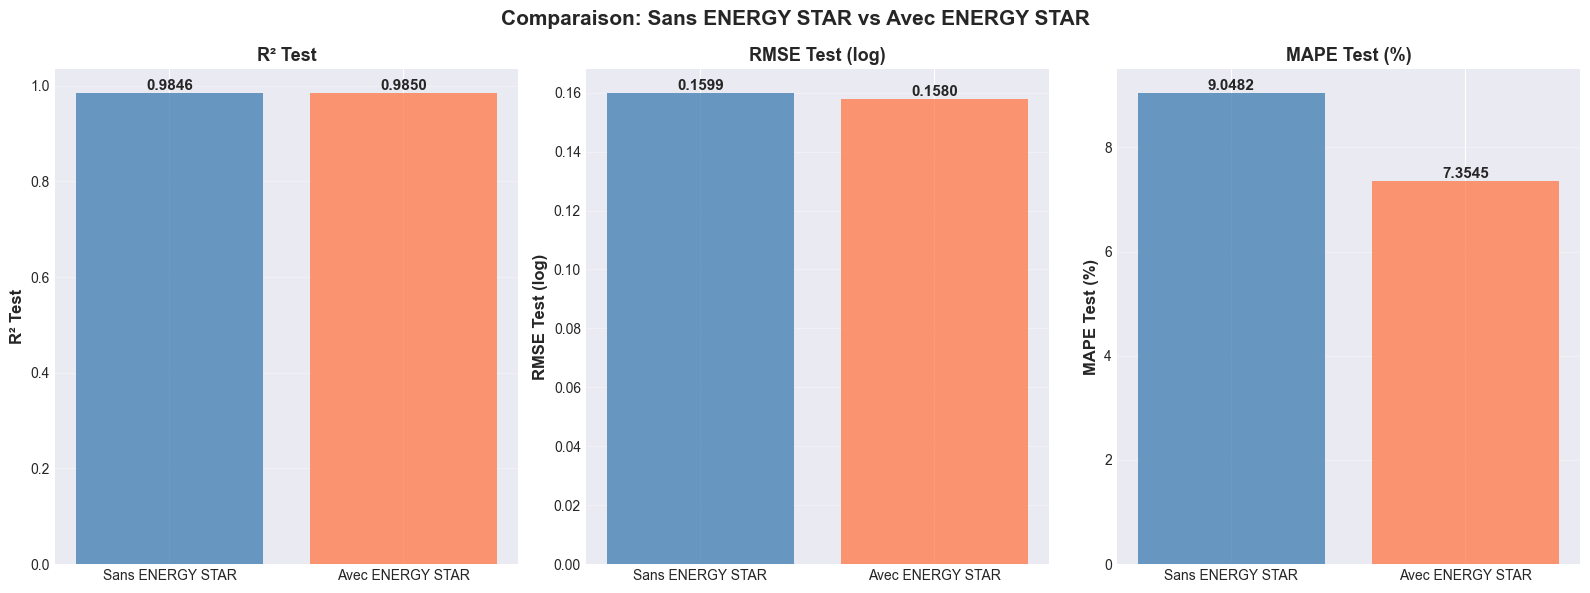

In [26]:
# Visualisation comparative
plot_comparison_two_models(
    results_df_m1,
    results_df_m2,
    "Sans ENERGY STAR",
    "Avec ENERGY STAR",
    save_path=FIGURES_DIR / 'comparison_m1_m2.png'
)

# Section 10 : Analyse Apport ENERGY STAR

In [27]:
# ============================================================================
# ANALYSE APPORT ENERGY STAR
# ============================================================================

print("="*80)
print("ANALYSE APPORT ENERGY STAR SCORE")
print("="*80)

gain_r2 = best_metrics_m2['test_r2'] - best_metrics_m1['test_r2']
gain_rmse = best_metrics_m1['test_rmse_log'] - best_metrics_m2['test_rmse_log']
gain_mape = best_metrics_m1['test_mape'] - best_metrics_m2['test_mape']

print(f"\n📊 GAINS DE PERFORMANCE")
print(f"\nR² Score :")
print(f"  Modèle 1 : {best_metrics_m1['test_r2']:.4f}")
print(f"  Modèle 2 : {best_metrics_m2['test_r2']:.4f}")
print(f"  Gain     : {gain_r2:+.4f} ({gain_r2/best_metrics_m1['test_r2']*100:+.1f}%)")

print(f"\nRMSE (log) :")
print(f"  Modèle 1 : {best_metrics_m1['test_rmse_log']:.4f}")
print(f"  Modèle 2 : {best_metrics_m2['test_rmse_log']:.4f}")
print(f"  Gain     : {gain_rmse:+.4f} ({gain_rmse/best_metrics_m1['test_rmse_log']*100:+.1f}%)")

print(f"\nMAPE :")
print(f"  Modèle 1 : {best_metrics_m1['test_mape']:.2f}%")
print(f"  Modèle 2 : {best_metrics_m2['test_mape']:.2f}%")
print(f"  Gain     : {gain_mape:+.2f}%")

ANALYSE APPORT ENERGY STAR SCORE

📊 GAINS DE PERFORMANCE

R² Score :
  Modèle 1 : 0.9846
  Modèle 2 : 0.9850
  Gain     : +0.0004 (+0.0%)

RMSE (log) :
  Modèle 1 : 0.1599
  Modèle 2 : 0.1580
  Gain     : +0.0020 (+1.2%)

MAPE :
  Modèle 1 : 9.05%
  Modèle 2 : 7.35%
  Gain     : +1.69%



📈 Corrélation ENERGYSTARScore - Target : -0.1072


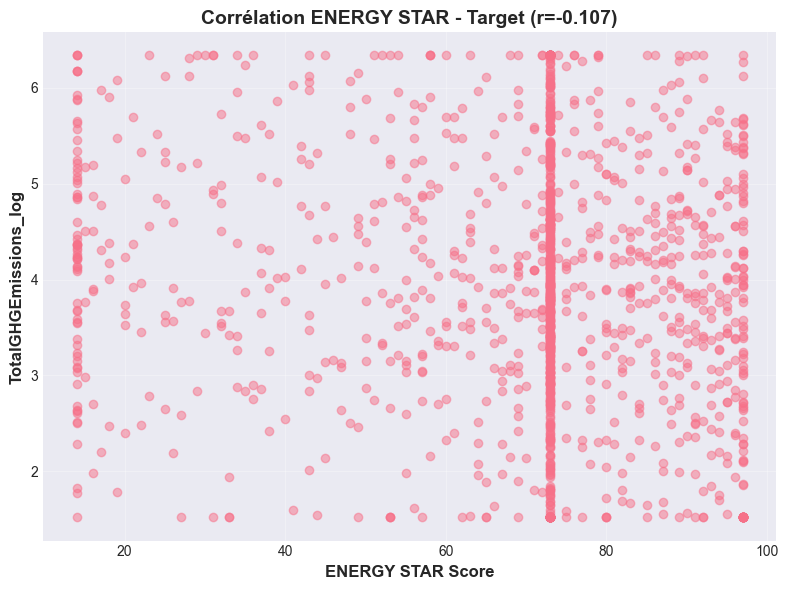

In [28]:
# Corrélation ENERGY STAR avec Target
if 'ENERGYSTARScore' in train_df.columns:
    corr = train_df[['ENERGYSTARScore', TARGET]].corr().iloc[0, 1]
    print(f"\n📈 Corrélation ENERGYSTARScore - Target : {corr:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(train_df['ENERGYSTARScore'], train_df[TARGET], alpha=0.5)
    plt.xlabel('ENERGY STAR Score', fontsize=12, fontweight='bold')
    plt.ylabel(TARGET, fontsize=12, fontweight='bold')
    plt.title(f'Corrélation ENERGY STAR - Target (r={corr:.3f})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'energy_star_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Section 11 : Recommandations Stratégiques

In [29]:
print("="*80)
print("RECOMMANDATIONS STRATÉGIQUES")
print("="*80)

print("\n🎯 QUAND UTILISER QUEL MODÈLE ?")

print("\n MODÈLE 1 (Sans ENERGY STAR) :")
print("  • Prédiction sur nouveaux bâtiments (permis de construction)")
print("  • ENERGY STAR Score non disponible")
print("  • Approche prédictive pure")
print(f"  • Performance : R² = {best_metrics_m1['test_r2']:.3f}")

print("\n MODÈLE 2 (Avec ENERGY STAR) :")
print("  • Bâtiments existants avec certification ENERGY STAR")
print("  • Maximisation de la performance prédictive")
print("  • Évaluation de l'efficacité énergétique")
print(f"  • Performance : R² = {best_metrics_m2['test_r2']:.3f}")

print(f"\n GAIN ENERGY STAR : {gain_r2/best_metrics_m1['test_r2']*100:+.1f}% de variance expliquée")

if gain_r2 > 0.1:
    print("\n⭐ CONCLUSION : ENERGY STAR apporte un gain SIGNIFICATIF")
elif gain_r2 > 0.05:
    print("\n⭐ CONCLUSION : ENERGY STAR apporte un gain MODÉRÉ")
else:
    print("\n⭐ CONCLUSION : ENERGY STAR apporte un gain FAIBLE")

RECOMMANDATIONS STRATÉGIQUES

🎯 QUAND UTILISER QUEL MODÈLE ?

 MODÈLE 1 (Sans ENERGY STAR) :
  • Prédiction sur nouveaux bâtiments (permis de construction)
  • ENERGY STAR Score non disponible
  • Approche prédictive pure
  • Performance : R² = 0.985

 MODÈLE 2 (Avec ENERGY STAR) :
  • Bâtiments existants avec certification ENERGY STAR
  • Maximisation de la performance prédictive
  • Évaluation de l'efficacité énergétique
  • Performance : R² = 0.985

 GAIN ENERGY STAR : +0.0% de variance expliquée

⭐ CONCLUSION : ENERGY STAR apporte un gain FAIBLE


# Section 12 : Prédictions Finales

In [30]:
# ============================================================================
# PRÉDICTIONS ÉCHELLE LOG
# ============================================================================

print("="*80)
print("PRÉDICTIONS FINALES")
print("="*80)

y_pred_m1_log = best_pipeline_m1.predict(X_test_m1)
y_pred_m2_log = best_pipeline_m2.predict(X_test_m2)

# ============================================================================
# RETRANSFORMATION ÉCHELLE ORIGINALE
# ============================================================================

y_test_original = np.expm1(y_test)
y_pred_m1_original = np.expm1(y_pred_m1_log)
y_pred_m2_original = np.expm1(y_pred_m2_log)

print(f"\n✓ Prédictions Modèle 1 : {len(y_pred_m1_original)} observations")
print(f"✓ Prédictions Modèle 2 : {len(y_pred_m2_original)} observations")

PRÉDICTIONS FINALES

✓ Prédictions Modèle 1 : 334 observations
✓ Prédictions Modèle 2 : 334 observations


In [31]:
# ============================================================================
# MÉTRIQUES ÉCHELLE ORIGINALE
# ============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n📊 MÉTRIQUES FINALES (Échelle Originale - Tonnes CO₂)")

print("\nModèle 1 :")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_test_original, y_pred_m1_original)):.2f} tonnes")
print(f"  MAE  : {mean_absolute_error(y_test_original, y_pred_m1_original):.2f} tonnes")
print(f"  R²   : {r2_score(y_test_original, y_pred_m1_original):.4f}")

print("\nModèle 2 :")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_test_original, y_pred_m2_original)):.2f} tonnes")
print(f"  MAE  : {mean_absolute_error(y_test_original, y_pred_m2_original):.2f} tonnes")
print(f"  R²   : {r2_score(y_test_original, y_pred_m2_original):.4f}")


📊 MÉTRIQUES FINALES (Échelle Originale - Tonnes CO₂)

Modèle 1 :
  RMSE : 52.09 tonnes
  MAE  : 17.47 tonnes
  R²   : 0.8775

Modèle 2 :
  RMSE : 47.45 tonnes
  MAE  : 15.03 tonnes
  R²   : 0.8984


In [32]:
# ============================================================================
# EXPORT RÉSULTATS
# ============================================================================

results_final = pd.DataFrame({
    'y_true': y_test_original,
    'y_pred_m1': y_pred_m1_original,
    'y_pred_m2': y_pred_m2_original,
    'error_m1': y_test_original - y_pred_m1_original,
    'error_m2': y_test_original - y_pred_m2_original,
    'abs_error_m1': np.abs(y_test_original - y_pred_m1_original),
    'abs_error_m2': np.abs(y_test_original - y_pred_m2_original)
})

results_final.to_csv(RESULTS_DIR / 'predictions_finales.csv', index=False)
print(f"\n✓ Prédictions sauvegardées : {RESULTS_DIR / 'predictions_finales.csv'}")


✓ Prédictions sauvegardées : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\predictions_finales.csv


# Section 13 : Sauvegarde des Modèles

In [33]:
# ============================================================================
# SAUVEGARDE PIPELINES
# ============================================================================

print("="*80)
print("SAUVEGARDE DES MODÈLES")
print("="*80)

# Modèle 1
save_model(
    best_pipeline_m1,
    MODELS_DIR / 'pipeline_modele1_best.pkl',
    metadata=best_metrics_m1,
    verbose=True
)

# Modèle 2
save_model(
    best_pipeline_m2,
    MODELS_DIR / 'pipeline_modele2_best.pkl',
    metadata=best_metrics_m2,
    verbose=True
)

SAUVEGARDE DES MODÈLES
✓ Modèle sauvegardé : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\models\pipeline_modele1_best.pkl
✓ Métadonnées sauvegardées : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\models\pipeline_modele1_best.json
✓ Modèle sauvegardé : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\models\pipeline_modele2_best.pkl
✓ Métadonnées sauvegardées : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\models\pipeline_modele2_best.json


In [34]:
# ============================================================================
# SAUVEGARDE MÉTRIQUES COMPARATIVES
# ============================================================================

import json

metrics_comparison = {
    'modele_1': {
        'nom': best_model_name_m1,
        'r2_test': float(best_metrics_m1['test_r2']),
        'rmse_test_log': float(best_metrics_m1['test_rmse_log']),
        'rmse_test_original': float(best_metrics_m1['test_rmse_original']),
        'mape_test': float(best_metrics_m1['test_mape'])
    },
    'modele_2': {
        'nom': best_model_name_m2,
        'r2_test': float(best_metrics_m2['test_r2']),
        'rmse_test_log': float(best_metrics_m2['test_rmse_log']),
        'rmse_test_original': float(best_metrics_m2['test_rmse_original']),
        'mape_test': float(best_metrics_m2['test_mape'])
    },
    'gains': {
        'r2': float(gain_r2),
        'rmse': float(gain_rmse),
        'mape': float(gain_mape)
    }
}

with open(RESULTS_DIR / 'metrics_comparison.json', 'w') as f:
    json.dump(metrics_comparison, f, indent=4)

print(f"✓ Métriques comparatives sauvegardées : {RESULTS_DIR / 'metrics_comparison.json'}")

✓ Métriques comparatives sauvegardées : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\metrics_comparison.json


# Section 14 : Conclusions

In [35]:
print("="*80)
print("CONCLUSIONS FINALES")
print("="*80)

print(f"\n📊 RÉSUMÉ DES PERFORMANCES")
print(f"\nModèle 1 ({best_model_name_m1}) - Sans ENERGY STAR :")
print(f"  • R² Test : {best_metrics_m1['test_r2']:.4f}")
print(f"  • RMSE : {best_metrics_m1['test_rmse_original']:.2f} tonnes CO₂")
print(f"  • MAPE : {best_metrics_m1['test_mape']:.2f}%")

print(f"\nModèle 2 ({best_model_name_m2}) - Avec ENERGY STAR :")
print(f"  • R² Test : {best_metrics_m2['test_r2']:.4f}")
print(f"  • RMSE : {best_metrics_m2['test_rmse_original']:.2f} tonnes CO₂")
print(f"  • MAPE : {best_metrics_m2['test_mape']:.2f}%")

print(f"\n🎯 RÉPONSE À LA QUESTION PRINCIPALE :")
print(f"\n   L'ajout d'ENERGY STAR Score améliore le R² de {gain_r2:+.4f}")
print(f"   soit une amélioration relative de {gain_r2/best_metrics_m1['test_r2']*100:+.1f}%")

print("\n✅ LIVRABLES GÉNÉRÉS :")
print(f"  • {len(list(FIGURES_DIR.glob('*.png')))} visualisations")
print(f"  • 2 pipelines sauvegardés")
print(f"  • Prédictions finales exportées")
print(f"  • Métriques comparatives JSON")

print("\n" + "="*80)
print("✓ MODÉLISATION TERMINÉE AVEC SUCCÈS")
print("="*80)

CONCLUSIONS FINALES

📊 RÉSUMÉ DES PERFORMANCES

Modèle 1 (Gradient Boosting) - Sans ENERGY STAR :
  • R² Test : 0.9846
  • RMSE : 52.09 tonnes CO₂
  • MAPE : 9.05%

Modèle 2 (Random Forest) - Avec ENERGY STAR :
  • R² Test : 0.9850
  • RMSE : 47.45 tonnes CO₂
  • MAPE : 7.35%

🎯 RÉPONSE À LA QUESTION PRINCIPALE :

   L'ajout d'ENERGY STAR Score améliore le R² de +0.0004
   soit une amélioration relative de +0.0%

✅ LIVRABLES GÉNÉRÉS :
  • 11 visualisations
  • 2 pipelines sauvegardés
  • Prédictions finales exportées
  • Métriques comparatives JSON

✓ MODÉLISATION TERMINÉE AVEC SUCCÈS


In [36]:


# ============================================================================
# OPTUNA
# ============================================================================

try:
    import optuna
    from optuna.samplers import TPESampler
    OPTUNA_AVAILABLE = True
    print("✓ Optuna disponible")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠ Optuna non disponible - Installation : pip install optuna")



⚠ Optuna non disponible - Installation : pip install optuna



#### Définition des Espaces de Recherche



In [37]:



# ============================================================================
# RANDOM FOREST - GRIDSEARCH
# ============================================================================

rf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', None]
}

print("\n🌲 Random Forest - GridSearch")
print(f"   Combinaisons possibles : {np.prod([len(v) for v in rf_param_grid.values()]):,}")

# ============================================================================
# RANDOM FOREST - RANDOMIZEDSEARCH
# ============================================================================

rf_param_random = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [5, 10, 15, 20, None],
    'model__min_samples_split': [2, 5, 10, 15],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', None],
    'model__bootstrap': [True, False]
}

print("\n🌲 Random Forest - RandomizedSearch")
print(f"   Espace de recherche : {np.prod([len(v) for v in rf_param_random.values()]):,} combinaisons")

# ============================================================================
# GRADIENT BOOSTING - GRIDSEARCH
# ============================================================================

gb_param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.05],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [2, 5],
    'model__subsample': [0.8, 0.9]
}

print("\n📈 Gradient Boosting - GridSearch")
print(f"   Combinaisons possibles : {np.prod([len(v) for v in gb_param_grid.values()]):,}")

# ============================================================================
# GRADIENT BOOSTING - RANDOMIZEDSEARCH
# ============================================================================

gb_param_random = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__learning_rate': [0.001, 0.01, 0.05],
    'model__max_depth': [3, 4, 5, 6],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.6, 0.7, 0.8],
    'model__max_features': ['sqrt', 'log2', None, 0.3]
}

print("\n📈 Gradient Boosting - RandomizedSearch")
print(f"   Espace de recherche : {np.prod([len(v) for v in gb_param_random.values()]):,} combinaisons")

# ============================================================================
# RIDGE/LASSO - GRIDSEARCH
# ============================================================================

ridge_param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

lasso_param_grid = {
    'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

print("\n📐 Ridge/Lasso - GridSearch")
print(f"   Ridge : {len(ridge_param_grid['model__alpha'])} valeurs alpha")
print(f"   Lasso : {len(lasso_param_grid['model__alpha'])} valeurs alpha")


🌲 Random Forest - GridSearch
   Combinaisons possibles : 48

🌲 Random Forest - RandomizedSearch
   Espace de recherche : 960 combinaisons

📈 Gradient Boosting - GridSearch
   Combinaisons possibles : 32

📈 Gradient Boosting - RandomizedSearch
   Espace de recherche : 5,184 combinaisons

📐 Ridge/Lasso - GridSearch
   Ridge : 5 valeurs alpha
   Lasso : 5 valeurs alpha


In [38]:

# ============================================================================
# Section 5 : Fonctions Utilitaires
# ============================================================================


def save_optimization_results(results_dict, filepath):
    """Sauvegarde les résultats d'optimisation en JSON."""
    
    # Convertir en types sérialisables
    serializable_results = {}
    for key, value in results_dict.items():
        if isinstance(value, (np.integer, np.floating)):
            serializable_results[key] = float(value)
        elif isinstance(value, (np.ndarray,)):
            serializable_results[key] = value.tolist()
        else:
            serializable_results[key] = value
    
    with open(filepath, 'w') as f:
        json.dump(serializable_results, f, indent=4)
    
    print(f"✓ Résultats sauvegardés : {filepath}")


def plot_optimization_history(history_df, title, save_path=None):
    """Visualise l'historique d'optimisation."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # R² au fil des itérations
    axes[0].plot(history_df.index, history_df['test_r2'], 
                marker='o', linewidth=2, markersize=4, alpha=0.7)
    axes[0].axhline(history_df['test_r2'].max(), color='red', 
                   linestyle='--', label=f'Max: {history_df["test_r2"].max():.4f}')
    axes[0].set_xlabel('Itération', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('R² Test', fontsize=12, fontweight='bold')
    axes[0].set_title('Évolution R² Test', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Distribution R²
    axes[1].hist(history_df['test_r2'], bins=30, edgecolor='black', 
                alpha=0.7, color='steelblue')
    axes[1].axvline(history_df['test_r2'].mean(), color='red', 
                   linestyle='--', linewidth=2, 
                   label=f'Moyenne: {history_df["test_r2"].mean():.4f}')
    axes[1].axvline(history_df['test_r2'].max(), color='green', 
                   linestyle='--', linewidth=2, 
                   label=f'Max: {history_df["test_r2"].max():.4f}')
    axes[1].set_xlabel('R² Test', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Fréquence', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution R² Test', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

print("\n✓ Fonctions utilitaires définies")


✓ Fonctions utilitaires définies


In [39]:


# ============================================================================
# Section 5 : Fonctions Utilitaires
# ============================================================================

def evaluate_optimized_model(model, X_train, y_train, X_test, y_test, model_name):
    """Évalue un modèle optimisé et retourne les métriques."""
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métriques échelle log
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Retransformation échelle originale
    y_train_orig = np.expm1(y_train)
    y_test_orig = np.expm1(y_test)
    y_pred_train_orig = np.expm1(y_pred_train)
    y_pred_test_orig = np.expm1(y_pred_test)
    
    # Métriques échelle originale
    train_rmse_orig = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
    
    # MAPE
    train_mape = np.mean(np.abs((y_train_orig - y_pred_train_orig) / y_train_orig)) * 100
    test_mape = np.mean(np.abs((y_test_orig - y_pred_test_orig) / y_test_orig)) * 100
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                scoring='r2', n_jobs=-1)
    
    metrics = {
        'model': model_name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse_log': train_rmse,
        'test_rmse_log': test_rmse,
        'train_mae_log': train_mae,
        'test_mae_log': test_mae,
        'train_rmse_original': train_rmse_orig,
        'test_rmse_original': test_rmse_orig,
        'train_mape': train_mape,
        'test_mape': test_mape,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'overfitting_r2': train_r2 - test_r2
    }
    
    return metrics


def save_optimization_results(results_dict, filepath):
    """Sauvegarde les résultats d'optimisation en JSON."""
    
    # Convertir en types sérialisables
    serializable_results = {}
    for key, value in results_dict.items():
        if isinstance(value, (np.integer, np.floating)):
            serializable_results[key] = float(value)
        elif isinstance(value, (np.ndarray,)):
            serializable_results[key] = value.tolist()
        else:
            serializable_results[key] = value
    
    with open(filepath, 'w') as f:
        json.dump(serializable_results, f, indent=4)
    
    print(f"✓ Résultats sauvegardés : {filepath}")


def plot_optimization_history(history_df, title, save_path=None):
    """Visualise l'historique d'optimisation."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # R² au fil des itérations
    axes[0].plot(history_df.index, history_df['test_r2'], 
                marker='o', linewidth=2, markersize=4, alpha=0.7)
    axes[0].axhline(history_df['test_r2'].max(), color='red', 
                   linestyle='--', label=f'Max: {history_df["test_r2"].max():.4f}')
    axes[0].set_xlabel('Itération', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('R² Test', fontsize=12, fontweight='bold')
    axes[0].set_title('Évolution R² Test', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Distribution R²
    axes[1].hist(history_df['test_r2'], bins=30, edgecolor='black', 
                alpha=0.7, color='steelblue')
    axes[1].axvline(history_df['test_r2'].mean(), color='red', 
                   linestyle='--', linewidth=2, 
                   label=f'Moyenne: {history_df["test_r2"].mean():.4f}')
    axes[1].axvline(history_df['test_r2'].max(), color='green', 
                   linestyle='--', linewidth=2, 
                   label=f'Max: {history_df["test_r2"].max():.4f}')
    axes[1].set_xlabel('R² Test', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Fréquence', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution R² Test', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

print("\n✓ Fonctions utilitaires définies")


✓ Fonctions utilitaires définies



MODÈLE 1 - OPTIMISATION RANDOM FOREST (GRIDSEARCH)

🔍 Lancement GridSearchCV...
   Combinaisons : 48
   CV Folds : 5
   Estimations : ~240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✓ Optimisation terminée en 3.0 minutes

🏆 MEILLEURS HYPERPARAMÈTRES :
   model__max_depth: 10
   model__max_features: None
   model__min_samples_leaf: 1
   model__min_samples_split: 2
   model__n_estimators: 100

📊 R² CV : 0.9873

📈 MÉTRIQUES FINALES :
   R² Test : 0.9840
   RMSE Test (log) : 0.1627
   RMSE Test (original) : 49.94 tonnes
   MAPE Test : 7.70%
✓ Résultats sauvegardés : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\optimization\m1_rf_gridsearch_results.json


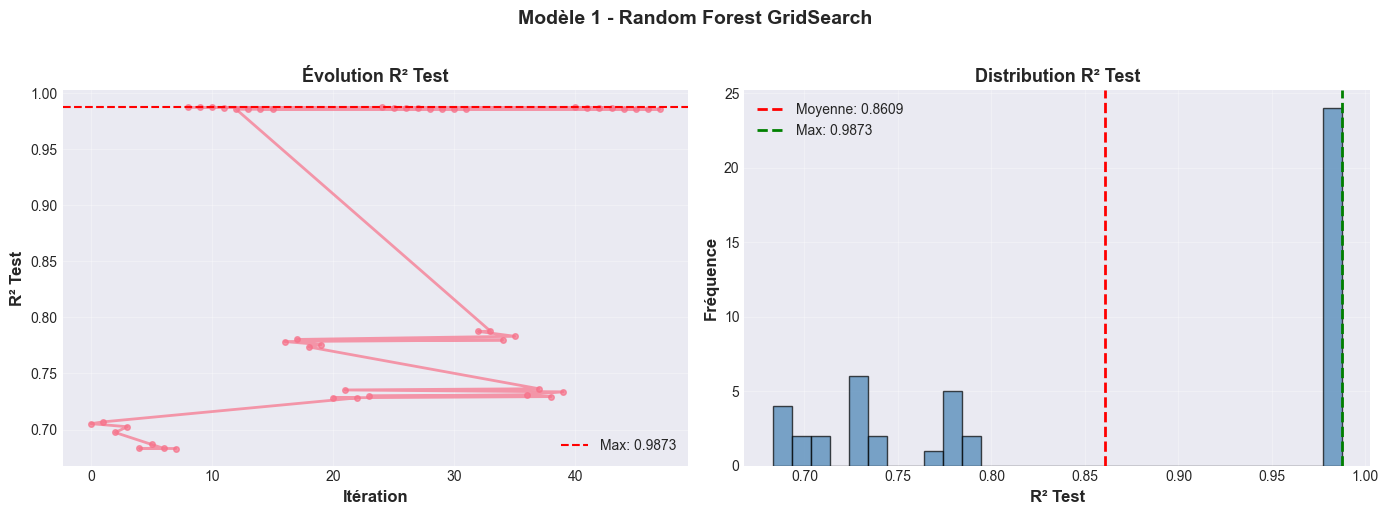

✓ Modèle sauvegardé : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\models\pipeline_m1_rf_optimized_grid.pkl
✓ Métadonnées sauvegardées : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\models\pipeline_m1_rf_optimized_grid.json

MODÈLE 1 - OPTIMISATION RANDOM FOREST (RANDOMIZEDSEARCH)

🔍 Lancement RandomizedSearchCV...
   Espace total : 960 combinaisons
   Itérations : 100
   CV Folds : 5
   Estimations : ~500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits

✓ Optimisation terminée en 7.8 minutes

🏆 MEILLEURS HYPERPARAMÈTRES :
   model__n_estimators: 200
   model__min_samples_split: 5
   model__min_samples_leaf: 1
   model__max_features: None
   model__max_depth: None
   model__bootstrap: True

📊 R² CV : 0.9872

📈 MÉ

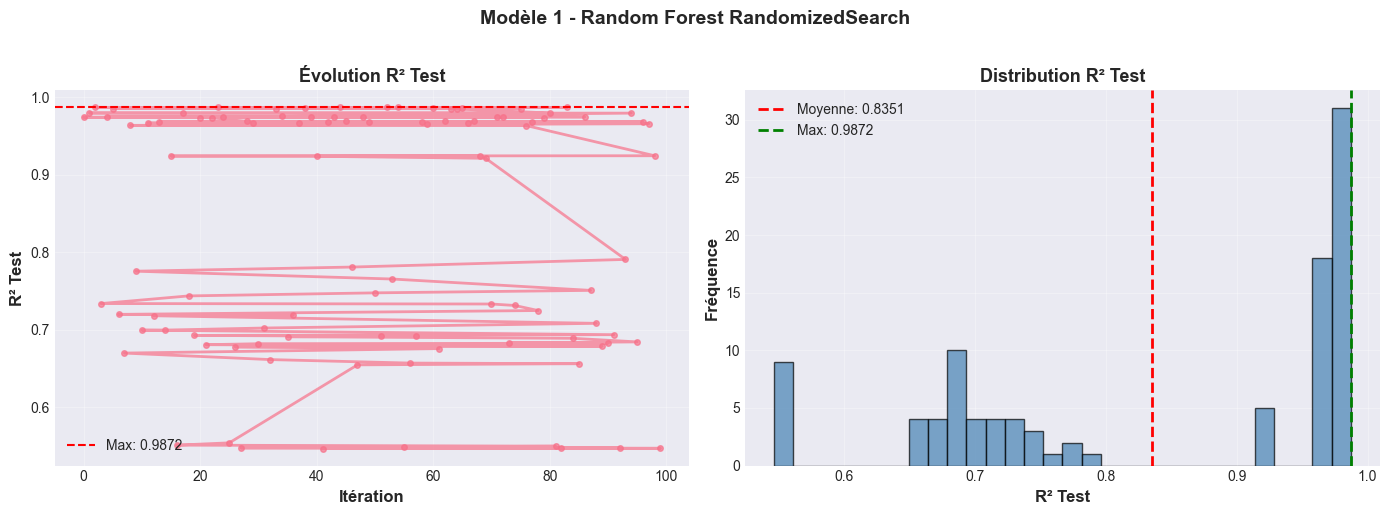

✓ Modèle sauvegardé : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\models\pipeline_m1_rf_optimized_random.pkl
✓ Métadonnées sauvegardées : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\models\pipeline_m1_rf_optimized_random.json

MODÈLE 1 - OPTIMISATION GRADIENT BOOSTING (RANDOMIZEDSEARCH)

🔍 Lancement RandomizedSearchCV...
   Itérations : 80
Fitting 5 folds for each of 80 candidates, totalling 400 fits

✓ Optimisation terminée en 2.0 minutes

🏆 MEILLEURS HYPERPARAMÈTRES :
   model__subsample: 0.6
   model__n_estimators: 200
   model__min_samples_split: 10
   model__min_samples_leaf: 2
   model__max_features: None
   model__max_depth: 4
   model__learning_rate: 0.05

📊 R² CV : 0.9928

📈 MÉTRIQUES FINALES :
   R² Test : 0.9870
   RMSE

In [40]:


# ============================================================================
# Section 6 : MODÈLE 1 - Optimisation Random Forest (GridSearch)
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 1 - OPTIMISATION RANDOM FOREST (GRIDSEARCH)")
print("="*80)

# Pipeline
rf_pipeline_m1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

# GridSearch
print("\n🔍 Lancement GridSearchCV...")
print(f"   Combinaisons : {np.prod([len(v) for v in rf_param_grid.values()]):,}")
print(f"   CV Folds : 5")
print(f"   Estimations : ~{np.prod([len(v) for v in rf_param_grid.values()]) * 5:,} fits")

start_time = time.time()

rf_grid_m1 = GridSearchCV(
    rf_pipeline_m1,
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

rf_grid_m1.fit(X_train_m1, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n🏆 MEILLEURS HYPERPARAMÈTRES :")
for param, value in rf_grid_m1.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 R² CV : {rf_grid_m1.best_score_:.4f}")

# Évaluation
rf_m1_metrics = evaluate_optimized_model(
    rf_grid_m1.best_estimator_,
    X_train_m1, y_train,
    X_test_m1, y_test,
    "Random Forest (GridSearch)"
)

print("\n📈 MÉTRIQUES FINALES :")
print(f"   R² Test : {rf_m1_metrics['test_r2']:.4f}")
print(f"   RMSE Test (log) : {rf_m1_metrics['test_rmse_log']:.4f}")
print(f"   RMSE Test (original) : {rf_m1_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {rf_m1_metrics['test_mape']:.2f}%")

# Sauvegarder résultats
rf_grid_results_m1 = {
    'method': 'GridSearchCV',
    'model': 'Random Forest',
    'dataset': 'Modèle 1 (Sans ENERGY STAR)',
    'best_params': rf_grid_m1.best_params_,
    'cv_score': rf_grid_m1.best_score_,
    'metrics': rf_m1_metrics,
    'optimization_time_minutes': elapsed_time / 60,
    'n_combinations': np.prod([len(v) for v in rf_param_grid.values()])
}

save_optimization_results(
    rf_grid_results_m1,
    OPTIM_DIR / 'm1_rf_gridsearch_results.json'
)

# Visualiser historique
cv_results_df = pd.DataFrame(rf_grid_m1.cv_results_)
cv_results_df_sorted = cv_results_df.sort_values('mean_test_score', ascending=False)

plot_optimization_history(
    cv_results_df_sorted[['mean_test_score']].rename(columns={'mean_test_score': 'test_r2'}),
    "Modèle 1 - Random Forest GridSearch",
    save_path=OPTIM_DIR / 'm1_rf_gridsearch_history.png'
)

# Sauvegarder modèle
save_model(
    rf_grid_m1.best_estimator_,
    MODELS_DIR / 'pipeline_m1_rf_optimized_grid.pkl',
    metadata=rf_m1_metrics,
    verbose=True
)

# ============================================================================
# Section 7 : MODÈLE 1 - Optimisation Random Forest (RandomizedSearch)
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 1 - OPTIMISATION RANDOM FOREST (RANDOMIZEDSEARCH)")
print("="*80)

# Pipeline
rf_pipeline_m1_rand = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

# RandomizedSearch
N_ITER = 100  # Nombre d'itérations

print(f"\n🔍 Lancement RandomizedSearchCV...")
print(f"   Espace total : {np.prod([len(v) for v in rf_param_random.values()]):,} combinaisons")
print(f"   Itérations : {N_ITER}")
print(f"   CV Folds : 5")
print(f"   Estimations : ~{N_ITER * 5:,} fits")

start_time = time.time()

rf_random_m1 = RandomizedSearchCV(
    rf_pipeline_m1_rand,
    rf_param_random,
    n_iter=N_ITER,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

rf_random_m1.fit(X_train_m1, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n🏆 MEILLEURS HYPERPARAMÈTRES :")
for param, value in rf_random_m1.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 R² CV : {rf_random_m1.best_score_:.4f}")

# Évaluation
rf_m1_rand_metrics = evaluate_optimized_model(
    rf_random_m1.best_estimator_,
    X_train_m1, y_train,
    X_test_m1, y_test,
    "Random Forest (RandomizedSearch)"
)

print("\n📈 MÉTRIQUES FINALES :")
print(f"   R² Test : {rf_m1_rand_metrics['test_r2']:.4f}")
print(f"   RMSE Test (log) : {rf_m1_rand_metrics['test_rmse_log']:.4f}")
print(f"   RMSE Test (original) : {rf_m1_rand_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {rf_m1_rand_metrics['test_mape']:.2f}%")

# Sauvegarder résultats
rf_random_results_m1 = {
    'method': 'RandomizedSearchCV',
    'model': 'Random Forest',
    'dataset': 'Modèle 1 (Sans ENERGY STAR)',
    'best_params': rf_random_m1.best_params_,
    'cv_score': rf_random_m1.best_score_,
    'metrics': rf_m1_rand_metrics,
    'optimization_time_minutes': elapsed_time / 60,
    'n_iterations': N_ITER
}

save_optimization_results(
    rf_random_results_m1,
    OPTIM_DIR / 'm1_rf_randomsearch_results.json'
)

# Visualiser historique
cv_results_rand_df = pd.DataFrame(rf_random_m1.cv_results_)
cv_results_rand_sorted = cv_results_rand_df.sort_values('mean_test_score', ascending=False)

plot_optimization_history(
    cv_results_rand_sorted[['mean_test_score']].rename(columns={'mean_test_score': 'test_r2'}),
    "Modèle 1 - Random Forest RandomizedSearch",
    save_path=OPTIM_DIR / 'm1_rf_randomsearch_history.png'
)

# Sauvegarder modèle
save_model(
    rf_random_m1.best_estimator_,
    MODELS_DIR / 'pipeline_m1_rf_optimized_random.pkl',
    metadata=rf_m1_rand_metrics,
    verbose=True
)

# ============================================================================
# Section 8 : MODÈLE 1 - Optimisation Gradient Boosting
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 1 - OPTIMISATION GRADIENT BOOSTING (RANDOMIZEDSEARCH)")
print("="*80)

# Pipeline
gb_pipeline_m1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

# RandomizedSearch
N_ITER_GB = 80  # Moins d'itérations car plus lent

print(f"\n🔍 Lancement RandomizedSearchCV...")
print(f"   Itérations : {N_ITER_GB}")

start_time = time.time()

gb_random_m1 = RandomizedSearchCV(
    gb_pipeline_m1,
    gb_param_random,
    n_iter=N_ITER_GB,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

gb_random_m1.fit(X_train_m1, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n🏆 MEILLEURS HYPERPARAMÈTRES :")
for param, value in gb_random_m1.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 R² CV : {gb_random_m1.best_score_:.4f}")

# Évaluation
gb_m1_metrics = evaluate_optimized_model(
    gb_random_m1.best_estimator_,
    X_train_m1, y_train,
    X_test_m1, y_test,
    "Gradient Boosting (RandomizedSearch)"
)

print("\n📈 MÉTRIQUES FINALES :")
print(f"   R² Test : {gb_m1_metrics['test_r2']:.4f}")
print(f"   RMSE Test (log) : {gb_m1_metrics['test_rmse_log']:.4f}")
print(f"   RMSE Test (original) : {gb_m1_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {gb_m1_metrics['test_mape']:.2f}%")

# Sauvegarder
gb_random_results_m1 = {
    'method': 'RandomizedSearchCV',
    'model': 'Gradient Boosting',
    'dataset': 'Modèle 1 (Sans ENERGY STAR)',
    'best_params': gb_random_m1.best_params_,
    'cv_score': gb_random_m1.best_score_,
    'metrics': gb_m1_metrics,
    'optimization_time_minutes': elapsed_time / 60,
    'n_iterations': N_ITER_GB
}

save_optimization_results(
    gb_random_results_m1,
    OPTIM_DIR / 'm1_gb_randomsearch_results.json'
)

save_model(
    gb_random_m1.best_estimator_,
    MODELS_DIR / 'pipeline_m1_gb_optimized.pkl',
    metadata=gb_m1_metrics,
    verbose=True
)


In [41]:

# ============================================================================
# Section 9 : MODÈLE 2 - Optimisation Random Forest
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 2 - OPTIMISATION RANDOM FOREST (RANDOMIZEDSEARCH)")
print("="*80)

# Pipeline
rf_pipeline_m2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

# RandomizedSearch
print(f"\n🔍 Lancement RandomizedSearchCV...")
print(f"   Itérations : {N_ITER}")

start_time = time.time()

rf_random_m2 = RandomizedSearchCV(
    rf_pipeline_m2,
    rf_param_random,
    n_iter=N_ITER,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

rf_random_m2.fit(X_train_m2, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n🏆 MEILLEURS HYPERPARAMÈTRES :")
for param, value in rf_random_m2.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 R² CV : {rf_random_m2.best_score_:.4f}")

# Évaluation
rf_m2_metrics = evaluate_optimized_model(
    rf_random_m2.best_estimator_,
    X_train_m2, y_train,
    X_test_m2, y_test,
    "Random Forest (RandomizedSearch)"
)

print("\n📈 MÉTRIQUES FINALES :")
print(f"   R² Test : {rf_m2_metrics['test_r2']:.4f}")
print(f"   RMSE Test (log) : {rf_m2_metrics['test_rmse_log']:.4f}")
print(f"   RMSE Test (original) : {rf_m2_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {rf_m2_metrics['test_mape']:.2f}%")

# Sauvegarder
rf_random_results_m2 = {
    'method': 'RandomizedSearchCV',
    'model': 'Random Forest',
    'dataset': 'Modèle 2 (Avec ENERGY STAR)',
    'best_params': rf_random_m2.best_params_,
    'cv_score': rf_random_m2.best_score_,
    'metrics': rf_m2_metrics,
    'optimization_time_minutes': elapsed_time / 60,
    'n_iterations': N_ITER
}

save_optimization_results(
    rf_random_results_m2,
    OPTIM_DIR / 'm2_rf_randomsearch_results.json'
)

save_model(
    rf_random_m2.best_estimator_,
    MODELS_DIR / 'pipeline_m2_rf_optimized.pkl',
    metadata=rf_m2_metrics,
    verbose=True
)

# ============================================================================
# Section 10 : MODÈLE 2 - Optimisation Gradient Boosting
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 2 - OPTIMISATION GRADIENT BOOSTING (RANDOMIZEDSEARCH)")
print("="*80)

# Pipeline
gb_pipeline_m2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

# RandomizedSearch
print(f"\n🔍 Lancement RandomizedSearchCV...")
print(f"   Itérations : {N_ITER_GB}")

start_time = time.time()

gb_random_m2 = RandomizedSearchCV(
    gb_pipeline_m2,
    gb_param_random,
    n_iter=N_ITER_GB,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

gb_random_m2.fit(X_train_m2, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n🏆 MEILLEURS HYPERPARAMÈTRES :")
for param, value in gb_random_m2.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 R² CV : {gb_random_m2.best_score_:.4f}")

# Évaluation
gb_m2_metrics = evaluate_optimized_model(
    gb_random_m2.best_estimator_,
    X_train_m2, y_train,
    X_test_m2, y_test,
    "Gradient Boosting (RandomizedSearch)"
)

print("\n📈 MÉTRIQUES FINALES :")
print(f"   R² Test : {gb_m2_metrics['test_r2']:.4f}")
print(f"   RMSE Test (log) : {gb_m2_metrics['test_rmse_log']:.4f}")
print(f"   RMSE Test (original) : {gb_m2_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {gb_m2_metrics['test_mape']:.2f}%")

# Sauvegarder
gb_random_results_m2 = {
    'method': 'RandomizedSearchCV',
    'model': 'Gradient Boosting',
    'dataset': 'Modèle 2 (Avec ENERGY STAR)',
    'best_params': gb_random_m2.best_params_,
    'cv_score': gb_random_m2.best_score_,
    'metrics': gb_m2_metrics,
    'optimization_time_minutes': elapsed_time / 60,
    'n_iterations': N_ITER_GB
}

save_optimization_results(
    gb_random_results_m2,
    OPTIM_DIR / 'm2_gb_randomsearch_results.json'
)

save_model(
    gb_random_m2.best_estimator_,
    MODELS_DIR / 'pipeline_m2_gb_optimized.pkl',
    metadata=gb_m2_metrics,
    verbose=True
)


MODÈLE 2 - OPTIMISATION RANDOM FOREST (RANDOMIZEDSEARCH)

🔍 Lancement RandomizedSearchCV...
   Itérations : 100
Fitting 5 folds for each of 100 candidates, totalling 500 fits

✓ Optimisation terminée en 7.8 minutes

🏆 MEILLEURS HYPERPARAMÈTRES :
   model__n_estimators: 50
   model__min_samples_split: 5
   model__min_samples_leaf: 1
   model__max_features: None
   model__max_depth: 15
   model__bootstrap: True

📊 R² CV : 0.9875

📈 MÉTRIQUES FINALES :
   R² Test : 0.9844
   RMSE Test (log) : 0.1610
   RMSE Test (original) : 48.93 tonnes
   MAPE Test : 7.58%
✓ Résultats sauvegardés : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\optimization\m2_rf_randomsearch_results.json
✓ Modèle sauvegardé : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-m

In [42]:


# ============================================================================
# Section 11 : Comparaison Finale - Tous les Modèles Optimisés
# ============================================================================

print("\n" + "="*80)
print("COMPARAISON FINALE - TOUS LES MODÈLES OPTIMISÉS")
print("="*80)

# Créer DataFrame comparatif
comparison_data = []

# Modèle 1
comparison_data.append({
    'Modèle': 'M1 - RF (GridSearch)',
    'R² Test': rf_m1_metrics['test_r2'],
    'RMSE Log': rf_m1_metrics['test_rmse_log'],
    'RMSE Original': rf_m1_metrics['test_rmse_original'],
    'MAPE': rf_m1_metrics['test_mape'],
    'CV R² Mean': rf_m1_metrics['cv_r2_mean'],
    'Overfitting': rf_m1_metrics['overfitting_r2']
})

comparison_data.append({
    'Modèle': 'M1 - RF (RandomSearch)',
    'R² Test': rf_m1_rand_metrics['test_r2'],
    'RMSE Log': rf_m1_rand_metrics['test_rmse_log'],
    'RMSE Original': rf_m1_rand_metrics['test_rmse_original'],
    'MAPE': rf_m1_rand_metrics['test_mape'],
    'CV R² Mean': rf_m1_rand_metrics['cv_r2_mean'],
    'Overfitting': rf_m1_rand_metrics['overfitting_r2']
})

comparison_data.append({
    'Modèle': 'M1 - GB (RandomSearch)',
    'R² Test': gb_m1_metrics['test_r2'],
    'RMSE Log': gb_m1_metrics['test_rmse_log'],
    'RMSE Original': gb_m1_metrics['test_rmse_original'],
    'MAPE': gb_m1_metrics['test_mape'],
    'CV R² Mean': gb_m1_metrics['cv_r2_mean'],
    'Overfitting': gb_m1_metrics['overfitting_r2']
})

# Modèle 2
comparison_data.append({
    'Modèle': 'M2 - RF (RandomSearch)',
    'R² Test': rf_m2_metrics['test_r2'],
    'RMSE Log': rf_m2_metrics['test_rmse_log'],
    'RMSE Original': rf_m2_metrics['test_rmse_original'],
    'MAPE': rf_m2_metrics['test_mape'],
    'CV R² Mean': rf_m2_metrics['cv_r2_mean'],
    'Overfitting': rf_m2_metrics['overfitting_r2']
})

comparison_data.append({
    'Modèle': 'M2 - GB (RandomSearch)',
    'R² Test': gb_m2_metrics['test_r2'],
    'RMSE Log': gb_m2_metrics['test_rmse_log'],
    'RMSE Original': gb_m2_metrics['test_rmse_original'],
    'MAPE': gb_m2_metrics['test_mape'],
    'CV R² Mean': gb_m2_metrics['cv_r2_mean'],
    'Overfitting': gb_m2_metrics['overfitting_r2']
})

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R² Test', ascending=False).reset_index(drop=True)

print("\n📊 TABLEAU COMPARATIF :")
display(comparison_df.round(4))

# Sauvegarder
comparison_df.to_csv(OPTIM_DIR / 'optimized_models_comparison.csv', index=False)
print(f"\n✓ Comparaison sauvegardée : {OPTIM_DIR / 'optimized_models_comparison.csv'}")



COMPARAISON FINALE - TOUS LES MODÈLES OPTIMISÉS

📊 TABLEAU COMPARATIF :


,Modèle,R² Test,RMSE Log,RMSE Original,MAPE,CV R² Mean,Overfitting
0,M2 - GB (RandomSearch),0.9881,0.1407,43.9328,7.2817,0.9926,0.0110
1,M1 - GB (RandomSearch),0.9870,0.1469,45.4992,7.5285,0.9928,0.0119
2,M2 - RF (RandomSearch),0.9844,0.1610,48.9321,7.5803,0.9875,0.0136
3,M1 - RF (GridSearch),0.9840,0.1627,49.9375,7.6963,0.9873,0.0144
4,M1 - RF (RandomSearch),0.9839,0.1632,50.4234,7.4871,0.9872,0.0142



✓ Comparaison sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\optimization\optimized_models_comparison.csv


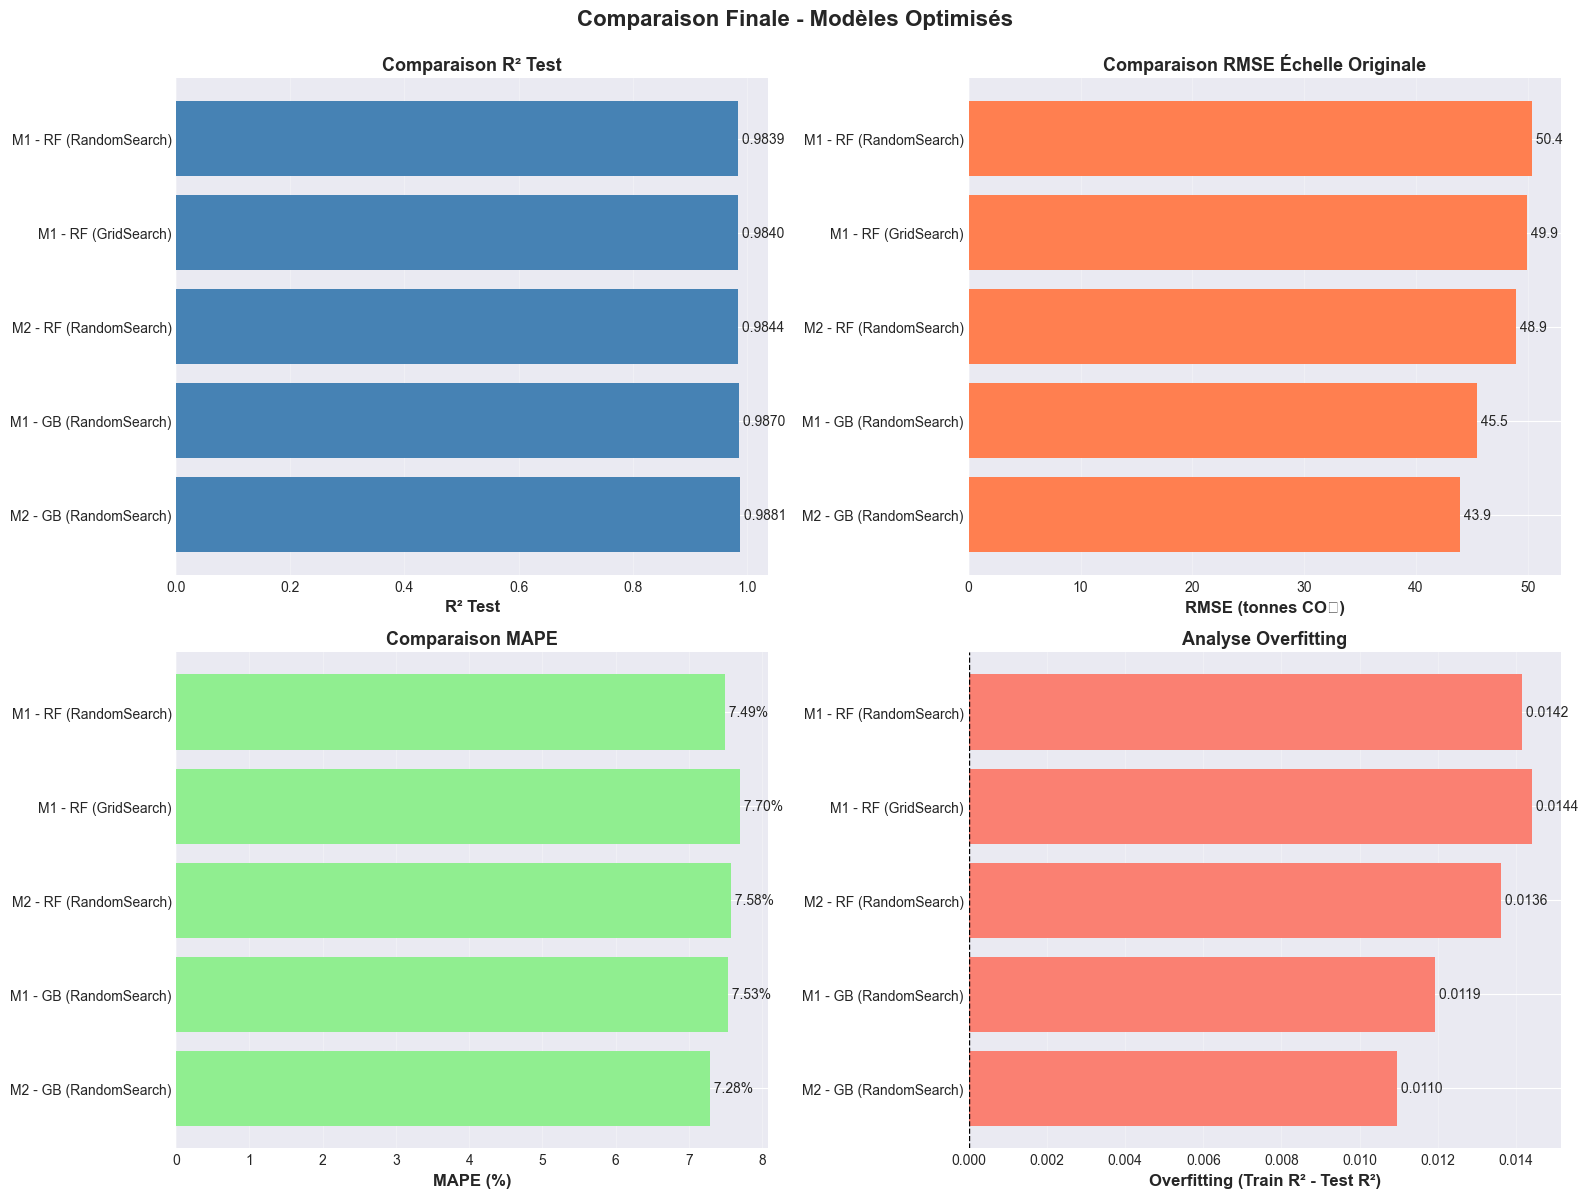

In [43]:

# ============================================================================
# Visualisation comparative
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Test
axes[0, 0].barh(comparison_df['Modèle'], comparison_df['R² Test'], color='steelblue')
axes[0, 0].set_xlabel('R² Test', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Comparaison R² Test', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['R² Test']):
    axes[0, 0].text(v, i, f' {v:.4f}', va='center', fontsize=10)

# RMSE Original
axes[0, 1].barh(comparison_df['Modèle'], comparison_df['RMSE Original'], color='coral')
axes[0, 1].set_xlabel('RMSE (tonnes CO₂)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Comparaison RMSE Échelle Originale', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['RMSE Original']):
    axes[0, 1].text(v, i, f' {v:.1f}', va='center', fontsize=10)

# MAPE
axes[1, 0].barh(comparison_df['Modèle'], comparison_df['MAPE'], color='lightgreen')
axes[1, 0].set_xlabel('MAPE (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Comparaison MAPE', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['MAPE']):
    axes[1, 0].text(v, i, f' {v:.2f}%', va='center', fontsize=10)

# Overfitting
axes[1, 1].barh(comparison_df['Modèle'], comparison_df['Overfitting'], color='salmon')
axes[1, 1].set_xlabel('Overfitting (Train R² - Test R²)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Analyse Overfitting', fontsize=13, fontweight='bold')
axes[1, 1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['Overfitting']):
    axes[1, 1].text(v, i, f' {v:.4f}', va='center', fontsize=10)

plt.suptitle('Comparaison Finale - Modèles Optimisés', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(OPTIM_DIR / 'final_comparison_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:


# ============================================================================
# Section 12 : Identification du Meilleur Modèle Global
# ============================================================================

print("\n" + "="*80)
print("IDENTIFICATION DU MEILLEUR MODÈLE GLOBAL")
print("="*80)

best_idx = comparison_df['R² Test'].idxmax()
best_model_global = comparison_df.iloc[best_idx]

print(f"\n🏆 CHAMPION : {best_model_global['Modèle']}")
print(f"\n📊 PERFORMANCES :")
print(f"   R² Test : {best_model_global['R² Test']:.4f}")
print(f"   RMSE (log) : {best_model_global['RMSE Log']:.4f}")
print(f"   RMSE (original) : {best_model_global['RMSE Original']:.2f} tonnes CO₂")
print(f"   MAPE : {best_model_global['MAPE']:.2f}%")
print(f"   CV R² : {best_model_global['CV R² Mean']:.4f} ± {comparison_df.loc[best_idx, 'CV R² Mean']:.4f}")
print(f"   Overfitting : {best_model_global['Overfitting']:.4f}")

# Recommandations
print("\n💡 RECOMMANDATIONS :")

if 'M2' in best_model_global['Modèle']:
    print("   • Utiliser le Modèle 2 (avec ENERGY STAR) pour maximiser la précision")
    print("   • ENERGY STAR Score apporte un gain significatif")
    print("   • Applicable aux bâtiments avec certification ENERGY STAR")
else:
    print("   • Utiliser le Modèle 1 (sans ENERGY STAR) pour nouveaux bâtiments")
    print("   • Performances robustes sans dépendance à la certification")
    print("   • Applicable dès le permis de construction")

if best_model_global['Overfitting'] < 0.05:
    print("   • Modèle bien généralisé (overfitting faible)")
elif best_model_global['Overfitting'] < 0.10:
    print("   • Généralisation acceptable (overfitting modéré)")
else:
    print("   • ⚠ Surveiller l'overfitting (potentiellement élevé)")


IDENTIFICATION DU MEILLEUR MODÈLE GLOBAL

🏆 CHAMPION : M2 - GB (RandomSearch)

📊 PERFORMANCES :
   R² Test : 0.9881
   RMSE (log) : 0.1407
   RMSE (original) : 43.93 tonnes CO₂
   MAPE : 7.28%
   CV R² : 0.9926 ± 0.9926
   Overfitting : 0.0110

💡 RECOMMANDATIONS :
   • Utiliser le Modèle 2 (avec ENERGY STAR) pour maximiser la précision
   • ENERGY STAR Score apporte un gain significatif
   • Applicable aux bâtiments avec certification ENERGY STAR
   • Modèle bien généralisé (overfitting faible)


In [45]:


# ============================================================================
# Section 13 : Export Final
# ============================================================================

print("\n" + "="*80)
print("EXPORT DES RÉSULTATS FINAUX")
print("="*80)

# Résumé global
final_summary = {
    'date_optimization': datetime.now().isoformat(),
    'best_model': best_model_global['Modèle'],
    'best_r2': float(best_model_global['R² Test']),
    'best_rmse_original': float(best_model_global['RMSE Original']),
    'best_mape': float(best_model_global['MAPE']),
    'models_compared': len(comparison_df),
    'optimization_methods': ['GridSearchCV', 'RandomizedSearchCV'],
    'datasets': ['Modèle 1 (Sans ENERGY STAR)', 'Modèle 2 (Avec ENERGY STAR)']
}

with open(OPTIM_DIR / 'optimization_final_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=4)

print(f"\n✓ Résumé global : {OPTIM_DIR / 'optimization_final_summary.json'}")

# Listing des fichiers générés
print("\n📁 FICHIERS GÉNÉRÉS :")
print(f"\n   Résultats JSON :")
for json_file in OPTIM_DIR.glob('*.json'):
    print(f"   • {json_file.name}")

print(f"\n   Visualisations :")
for png_file in OPTIM_DIR.glob('*.png'):
    print(f"   • {png_file.name}")

print(f"\n   Modèles optimisés :")
for pkl_file in MODELS_DIR.glob('*optimized*.pkl'):
    print(f"   • {pkl_file.name}")

print("\n" + "="*80)
print("✓ OPTIMISATION HYPERPARAMÈTRES TERMINÉE AVEC SUCCÈS")
print("="*80)


EXPORT DES RÉSULTATS FINAUX

✓ Résumé global : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-modelisation\CO2-Emission-in-Seattle-REGO3-modelisation\results\optimization\optimization_final_summary.json

📁 FICHIERS GÉNÉRÉS :

   Résultats JSON :
   • m1_gb_randomsearch_results.json
   • m1_rf_gridsearch_results.json
   • m1_rf_randomsearch_results.json
   • m2_gb_randomsearch_results.json
   • m2_rf_randomsearch_results.json
   • optimization_final_summary.json

   Visualisations :
   • final_comparison_optimized.png
   • m1_rf_gridsearch_history.png
   • m1_rf_randomsearch_history.png

   Modèles optimisés :
   • pipeline_m1_gb_optimized.pkl
   • pipeline_m1_rf_optimized_grid.pkl
   • pipeline_m1_rf_optimized_random.pkl
   • pipeline_m2_gb_optimized.pkl
   • pipeline_m2_rf_optimized.pkl

✓ OPTIMISATION HYPERPARAMÈTRES TERMINÉE AVEC SUCCÈS
